In [1]:
#Auto-save / Auto-reload
%autosave 1

%load_ext autoreload
%autoreload 2

Autosaving every 1 seconds


# Imports

In [2]:
import os

# for EDA
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt # https://scikit-plot.readthedocs.io/en/stable/Quickstart.htm
from IPython.display import display

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import ComplementNB

# tuning and metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, precision_recall_curve, auc, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mutual_info_score

# Deployment
import bentoml

# still need?
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score


In [3]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data-df.csv')
df2 = pd.read_csv('./data/healthcare-dataset-stroke-data-df2.csv')

# Modeling

The modeling proccess is to first test possable viable models, then select the best models, and create a baseline to compare the tuning process against.

**Linear Regression** is a poor choice for clasification output problems and better suited for continuous output problems. While the label is binary the model could provide values outside of that range.

Researching ML models and the general concesses from ML engineers show the following models best for our label which is a binary classifier (stroke 1 or 0). There are numerous articles and research papers but this [article](https://towardsdatascience.com/pros-and-cons-of-various-classification-ml-algorithms-3b5bfb3c87d6) and this [article](https://towardsdatascience.com/top-10-binary-classification-algorithms-a-beginners-guide-feeacbd7a3e2) sum up the reasoning.

### Data Prep

#### DF

In [4]:
# Split: df_train / df_val

df_full_train, df_val = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_test = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.stroke.values
y_val = df_val.stroke.values
y_test = df_test.stroke.values

del df_train['stroke']
del df_val['stroke']
del df_test['stroke']

In [5]:
# x_train

train_dict = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(train_dict)


In [6]:
x_train.shape, y_train.shape

((3065, 20), (3065,))

In [7]:
# x_val

val_dict = df_val.to_dict(orient='records')
x_val = dv.transform(val_dict)

In [8]:
# x_test

test_dict = df_test.to_dict(orient='records')
x_test = dv.transform(test_dict)

#### DF2

In [9]:
# df2_train / df2_val / df2_test

df2_full_train, df2_val = train_test_split(df2, test_size=0.2, random_state=1)
df2_train, df2_test = train_test_split(df2_full_train, test_size=0.25, random_state=1)

df2_train = df2_train.reset_index(drop=True)
df2_val = df2_val.reset_index(drop=True)
df2_test = df2_test.reset_index(drop=True)

y_train2 = df2_train.stroke.values
y_val2 = df2_val.stroke.values
y_test2 = df2_test.stroke.values

del df2_train['stroke']
del df2_val['stroke']
del df2_test['stroke']

In [10]:
# x_val2

val2_dict = df2_val.to_dict(orient='records')
x_val2 = dv.transform(val2_dict)

In [11]:
# x_train2

train2_dict = df2_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
x_train2 = dv.fit_transform(train2_dict)


In [12]:
# x_test2

test2_dict = df2_test.to_dict(orient='records')
x_test2 = dv.transform(test2_dict)

### Model Comparison

In [13]:
# def model_run(models)

def model_run(models,x_train,y_train,x_val,y_val):
  for name, model in models:
      model = model
      model.fit(x_train, y_train)

      print(" ")
      print("Model: ",name)
      print('Validation Accuracy: ', accuracy_score(y_val, model.predict(x_val)))
      print('Training Accuracy: ', accuracy_score(y_train, model.predict(x_train)))
      print(" ")

      plt.figure()
      cf_matrix = confusion_matrix(y_val, model.predict(x_val))
      sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
      plt.title('Confusion Matrix: {}'.format(name))
      plt.xticks([0.5, 1.5], ['Predicted Non-Stroke', 'Predicted Stroke'])
      plt.yticks([0.5, 1.5], ['Actual Non-Stroke', 'Actual Stroke'])
      plt.show()

      print(" ")

      skplt.metrics.plot_roc(y_val, model.predict_proba(x_val))
      plt.title('ROC Curves: {}'.format(name))
      plt.show()

In [14]:
# Model Selection
start_models = [('Logistic Regression', LogisticRegression(max_iter=4000,random_state=10)), # max_iter=4000 due to convergence error
          ('Decision Tree Classifier', DecisionTreeClassifier(random_state=10)),
          ('Random Forest', RandomForestClassifier(random_state=10)),
          ('Linear Discriminant Analyzer', LinearDiscriminantAnalysis()),
          ('Ada Boost', AdaBoostClassifier(random_state=1)),
          ('KNN', KNeighborsClassifier()),
          ('Support Vector Machine', SVC(probability =True, random_state=10)),
          ('XG Boost', XGBClassifier(random_state=10)),
          ('Cat Boost', CatBoostClassifier(logging_level = 'Silent')),
          ('Naive Bayes', ComplementNB())]

Logisitc Regression interation increased to resolve [convergence error](https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter)

#### DF all models

 
Model:  Logistic Regression
Validation Accuracy:  0.9412915851272016
Training Accuracy:  0.9510603588907015
 


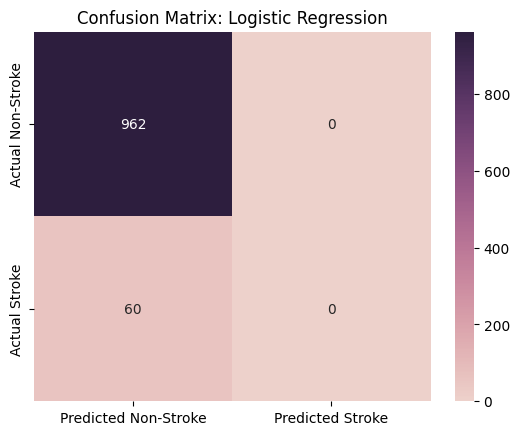

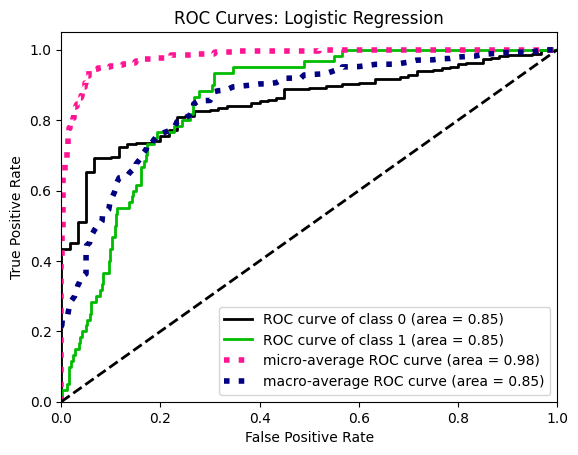

 
Model:  Decision Tree Classifier
Validation Accuracy:  0.9070450097847358
Training Accuracy:  1.0
 


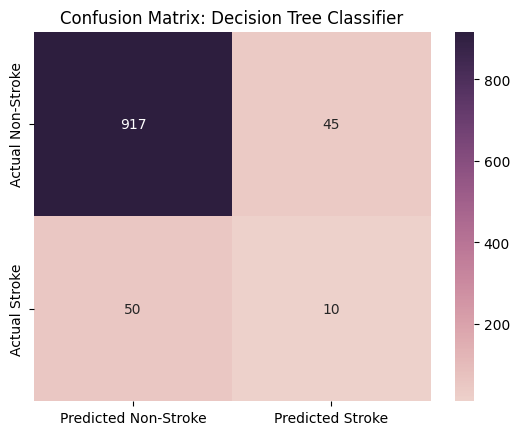

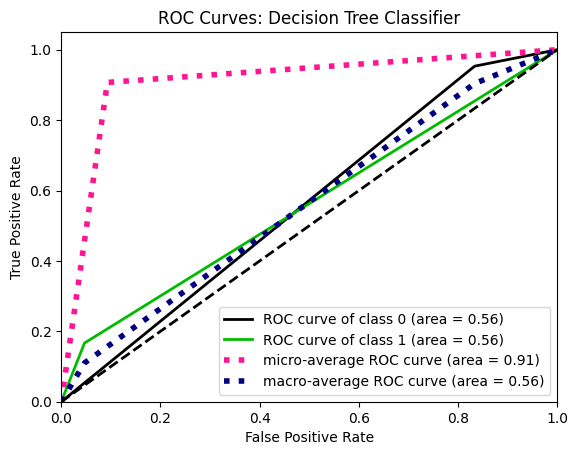

 
Model:  Random Forest
Validation Accuracy:  0.9403131115459883
Training Accuracy:  0.999673735725938
 


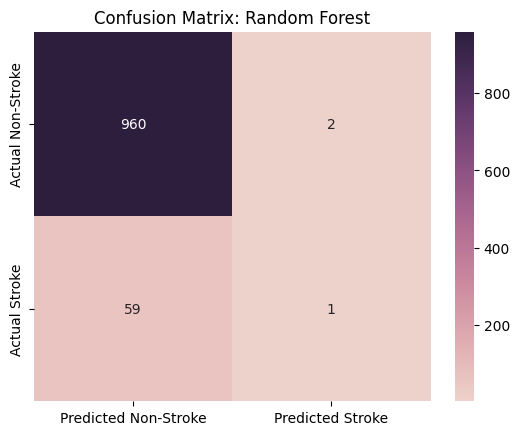

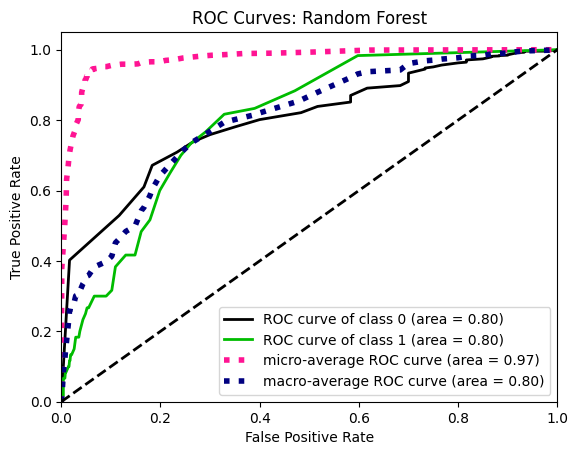

 
Model:  Linear Discriminant Analyzer
Validation Accuracy:  0.9324853228962818
Training Accuracy:  0.9468189233278956
 


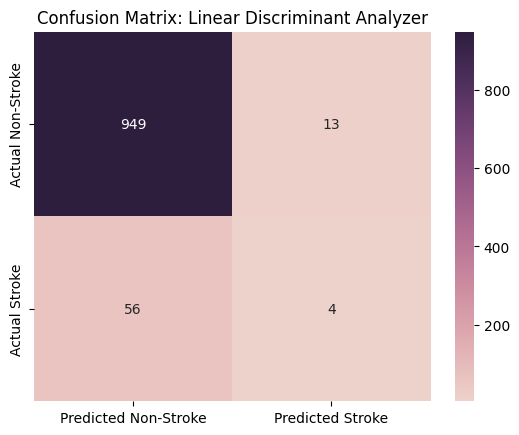

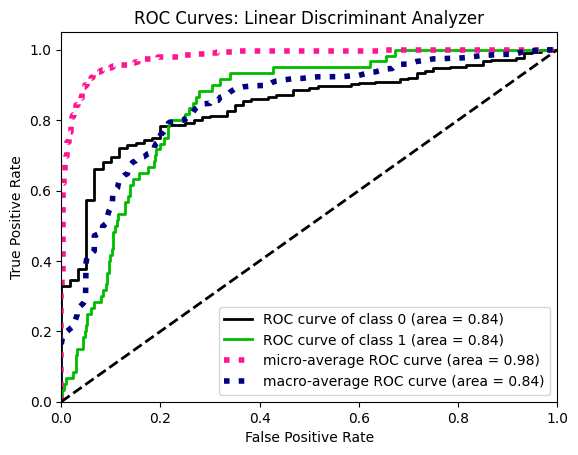

/home/blackitalian/miniconda3/envs/stroke/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


 
Model:  Ada Boost
Validation Accuracy:  0.9481409001956947
Training Accuracy:  0.9533442088091354
 


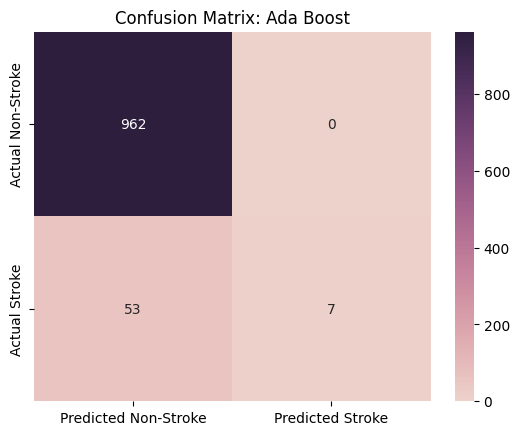

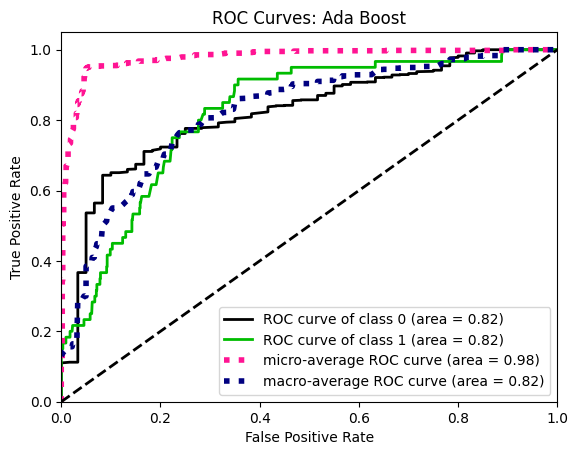

 
Model:  KNN
Validation Accuracy:  0.9354207436399217
Training Accuracy:  0.9523654159869495
 


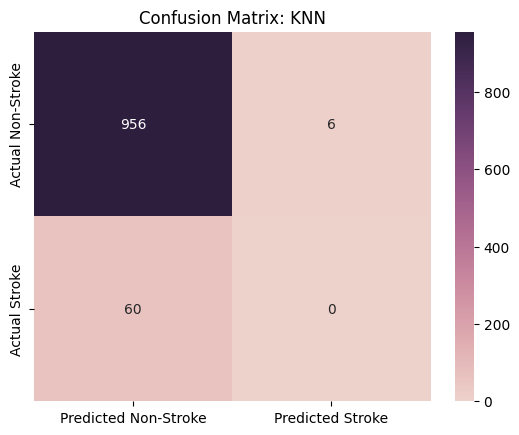

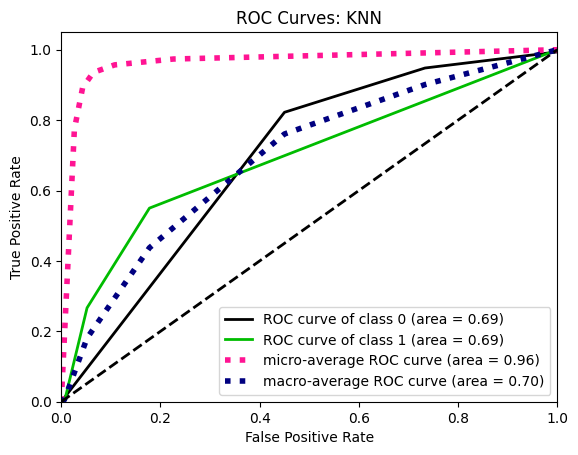

 
Model:  Support Vector Machine
Validation Accuracy:  0.9412915851272016
Training Accuracy:  0.9510603588907015
 


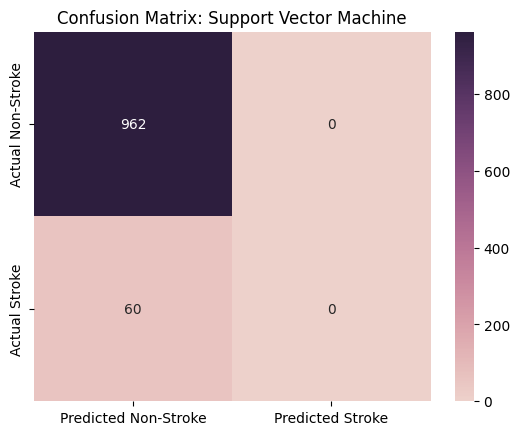

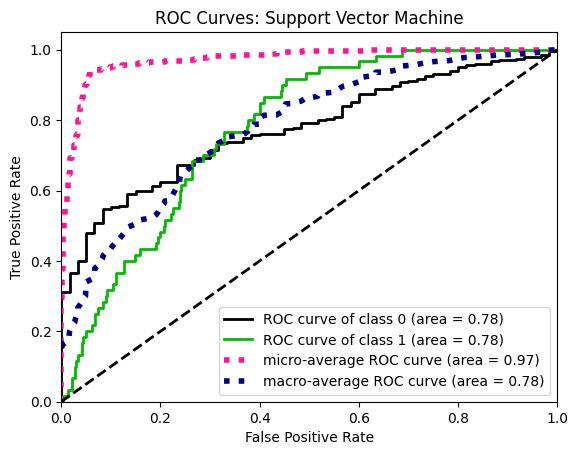

 
Model:  XG Boost
Validation Accuracy:  0.9412915851272016
Training Accuracy:  1.0
 


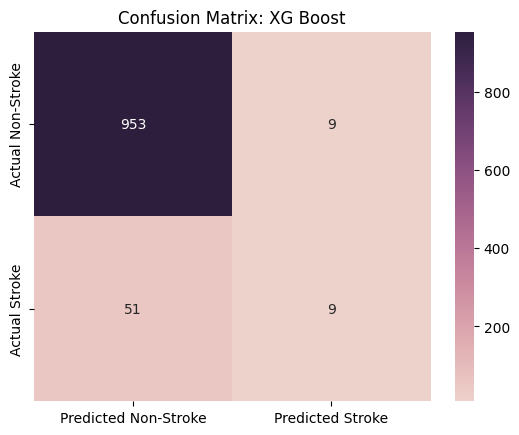

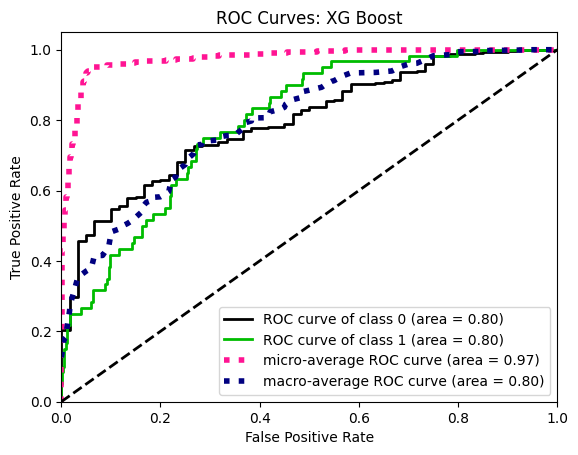

 
Model:  Cat Boost
Validation Accuracy:  0.9452054794520548
Training Accuracy:  0.9804241435562806
 


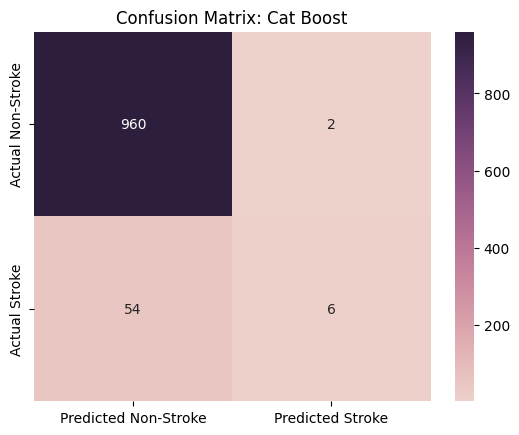

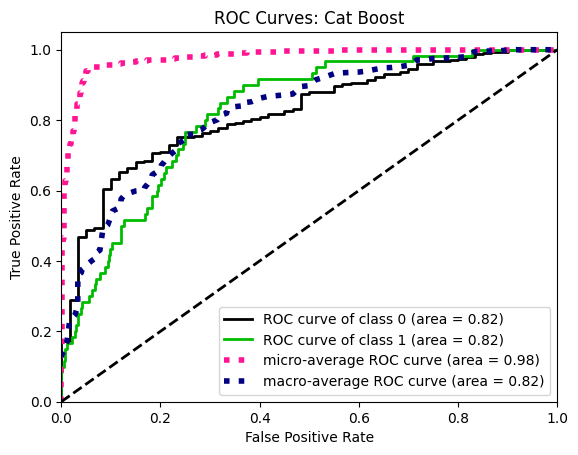

 
Model:  Naive Bayes
Validation Accuracy:  0.6448140900195695
Training Accuracy:  0.6378466557911908
 


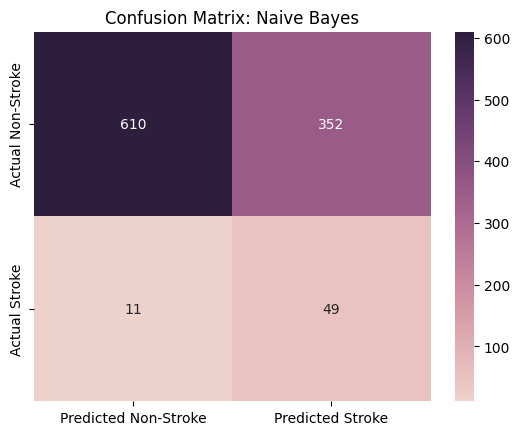

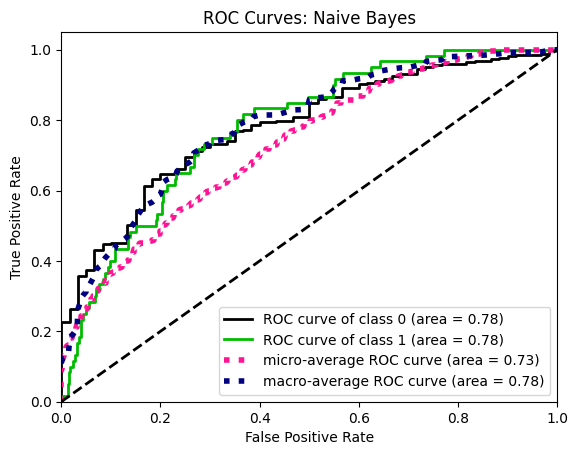

In [15]:
# Run all models
model_run(start_models,x_train,y_train,x_val,y_val)

Stroke prediction is terrible, Naive Bayes is the best performer.

#### DF2 all models

 
Model:  Logistic Regression
Validation Accuracy:  0.9412915851272016
Training Accuracy:  0.9513866231647634
 


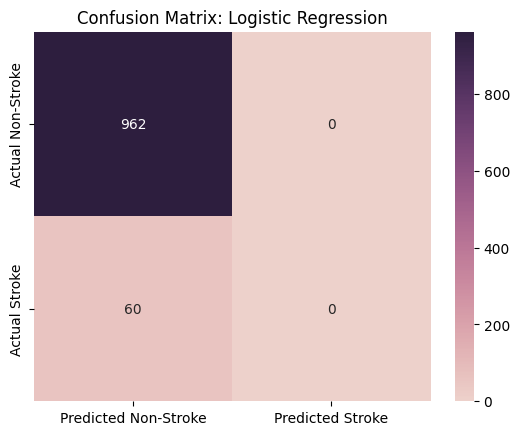

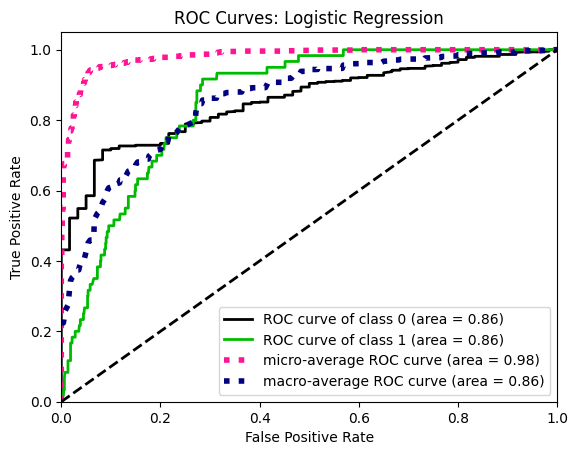

 
Model:  Decision Tree Classifier
Validation Accuracy:  0.8620352250489237
Training Accuracy:  0.9947797716150082
 


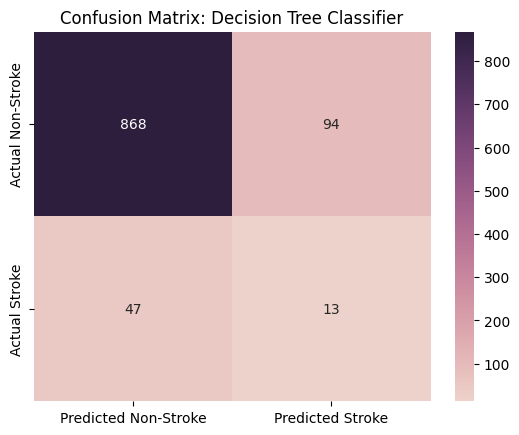

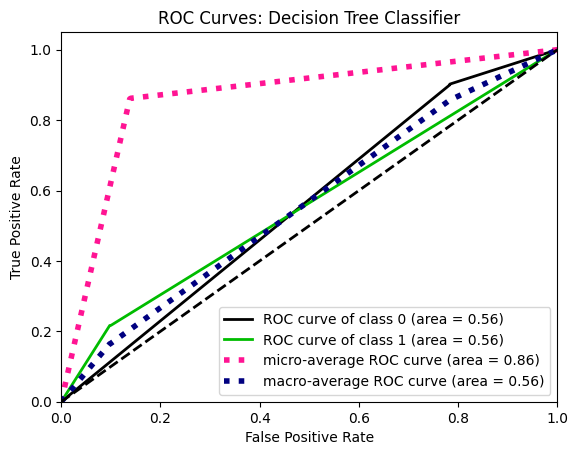

 
Model:  Random Forest
Validation Accuracy:  0.9422700587084148
Training Accuracy:  0.9944535073409462
 


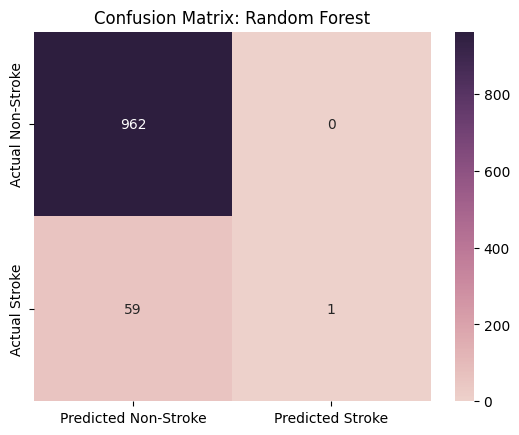

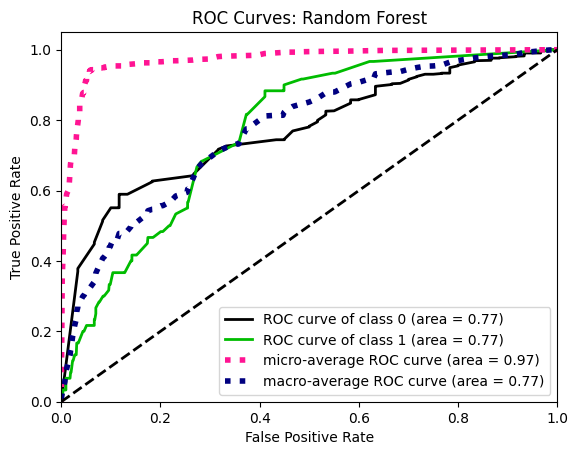

 
Model:  Linear Discriminant Analyzer
Validation Accuracy:  0.9266144814090019
Training Accuracy:  0.9471451876019575
 


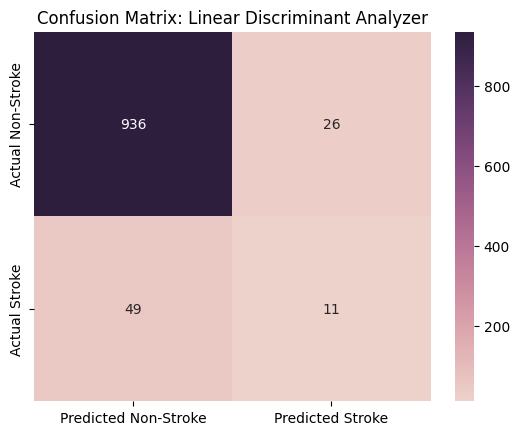

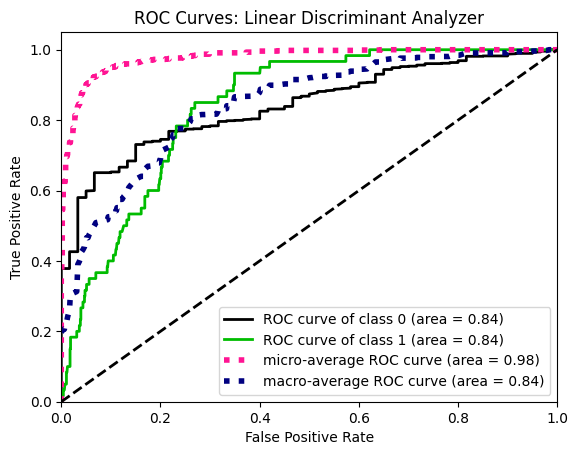

 
Model:  Ada Boost
Validation Accuracy:  0.9412915851272016
Training Accuracy:  0.9513866231647634
 


/home/blackitalian/miniconda3/envs/stroke/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


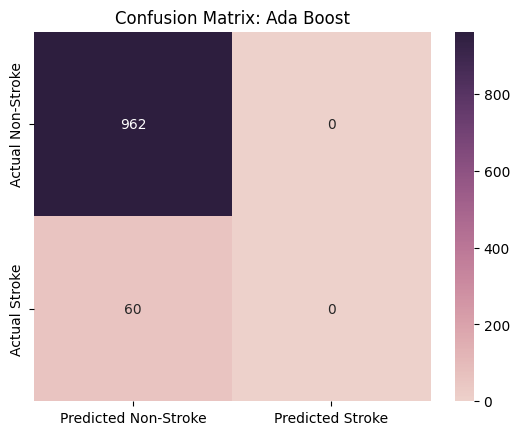

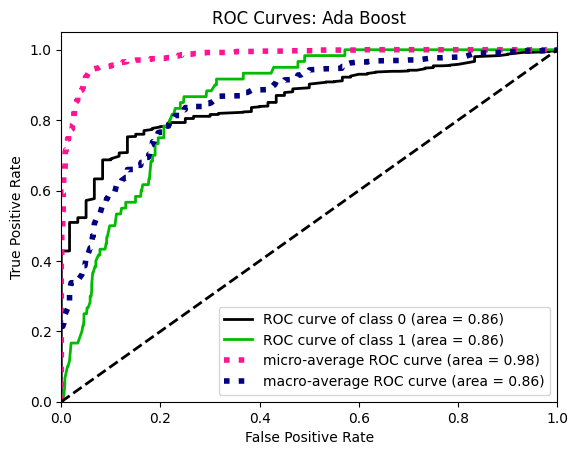

 
Model:  KNN
Validation Accuracy:  0.9373776908023483
Training Accuracy:  0.9530179445350734
 


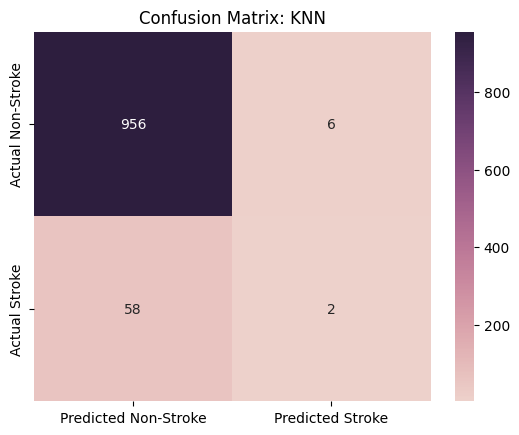

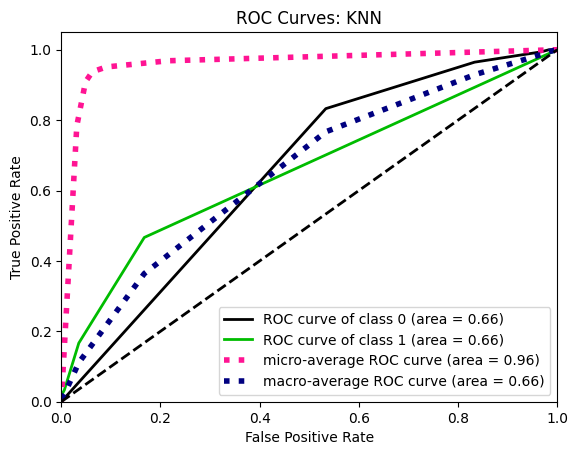

 
Model:  Support Vector Machine
Validation Accuracy:  0.9412915851272016
Training Accuracy:  0.9510603588907015
 


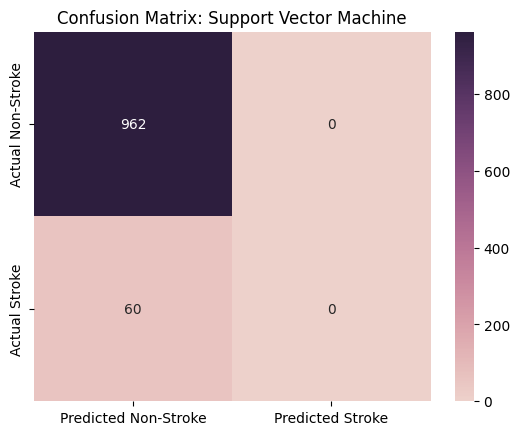

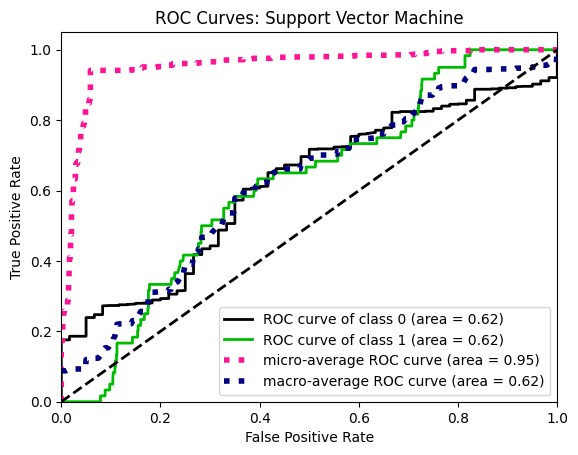

 
Model:  XG Boost
Validation Accuracy:  0.9383561643835616
Training Accuracy:  0.9800978792822186
 


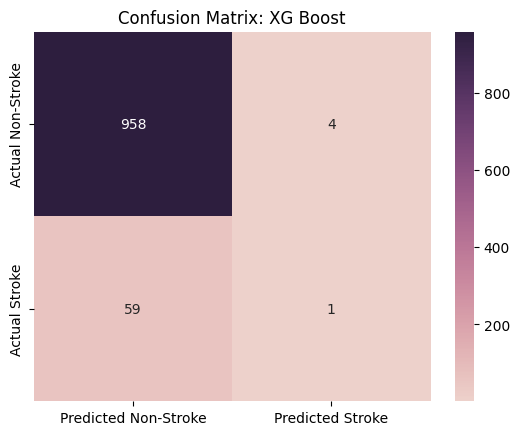

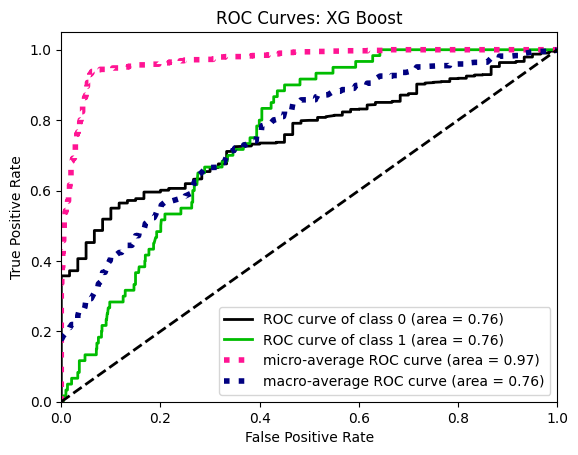

 
Model:  Cat Boost
Validation Accuracy:  0.9354207436399217
Training Accuracy:  0.9690048939641109
 


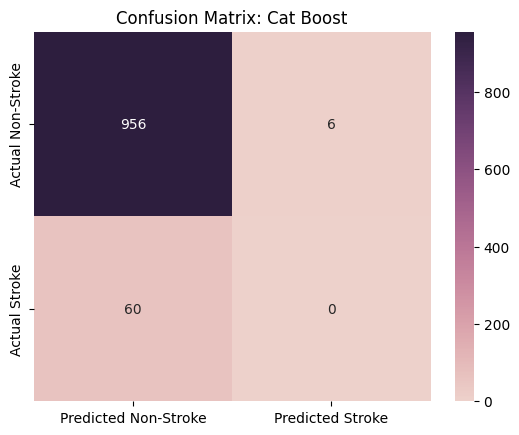

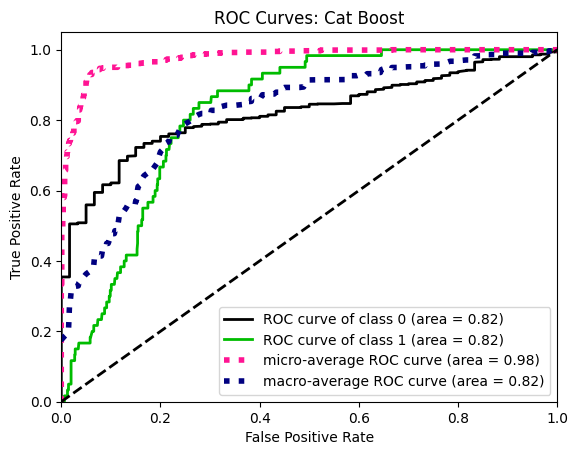

 
Model:  Naive Bayes
Validation Accuracy:  0.512720156555773
Training Accuracy:  0.6055464926590538
 


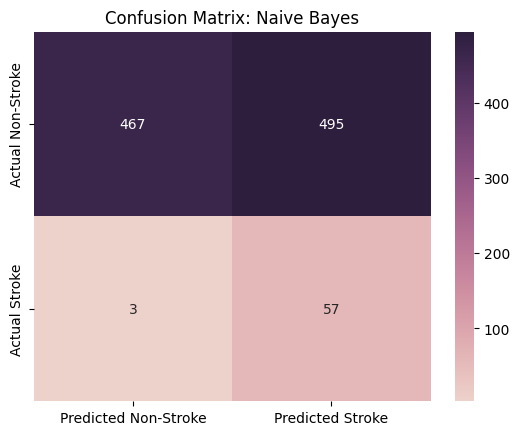

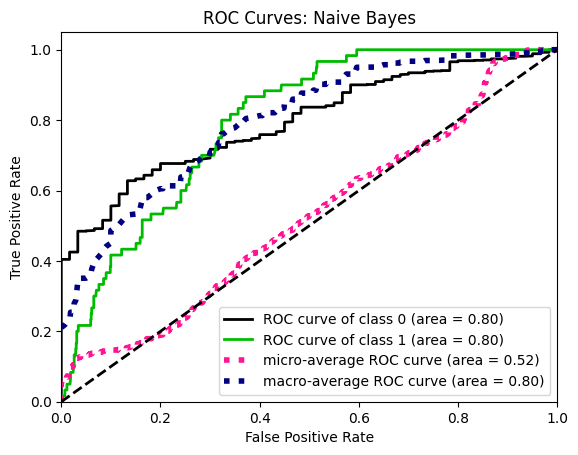

In [16]:
# Run all models 2
model_run(start_models,x_train2,y_train2,x_val2,y_val2)

Similar results as first run but Naive Bayes performed much better on positive stroke prediction.

### SMOTE

Oversampling with SMOTE

In [17]:
# def training_smote(x,y) - to address the stroke imbalance

# ONLY APPLY SMOTE TO TRAIN!
def training_smote(x,y):
    smt = SMOTE(random_state=42,sampling_strategy='minority')
    a, b = smt.fit_resample(x,y)

    return a, b

In [18]:
x_train_smt, y_train_smt = training_smote(x_train, y_train)

In [19]:
x_train_smt.shape

(5830, 20)

In [20]:
x_train2_smt, y_train2_smt = training_smote(x_train2, y_train2)

In [21]:
len(x_train2)

3065

SMOTE is not able to generate data

### All Models

#### SMOTE DF all models

 
Model:  Logistic Regression
Validation Accuracy:  0.7367906066536204
Training Accuracy:  0.7775300171526587
 


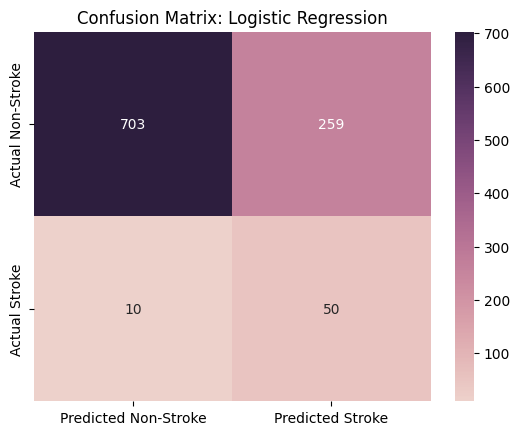

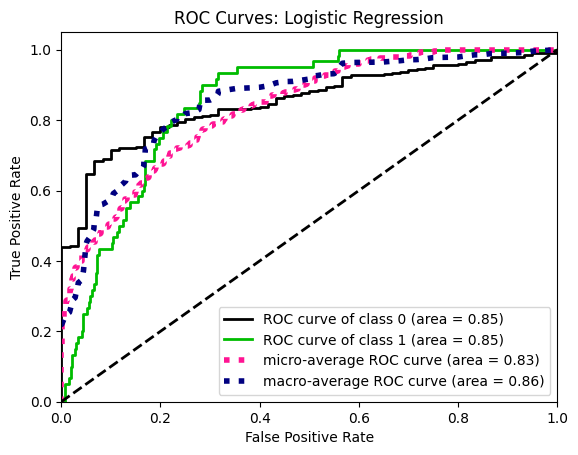

 
Model:  Decision Tree Classifier
Validation Accuracy:  0.901174168297456
Training Accuracy:  1.0
 


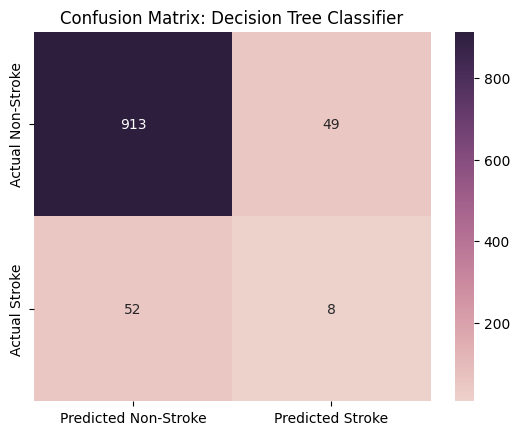

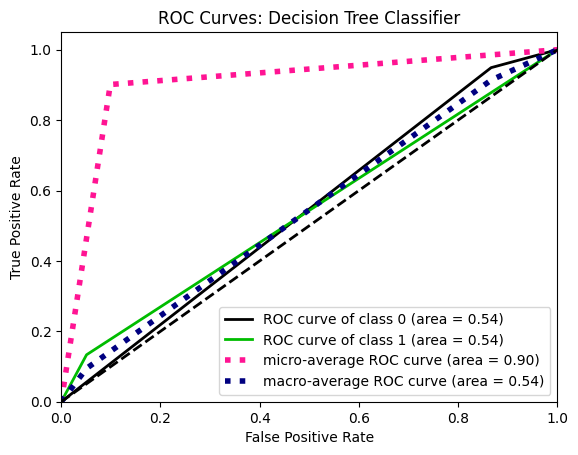

 
Model:  Random Forest
Validation Accuracy:  0.9393346379647749
Training Accuracy:  1.0
 


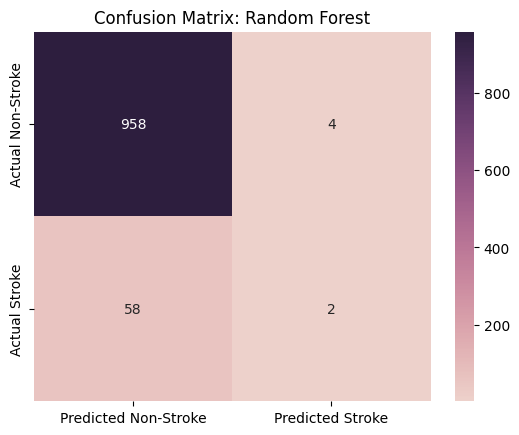

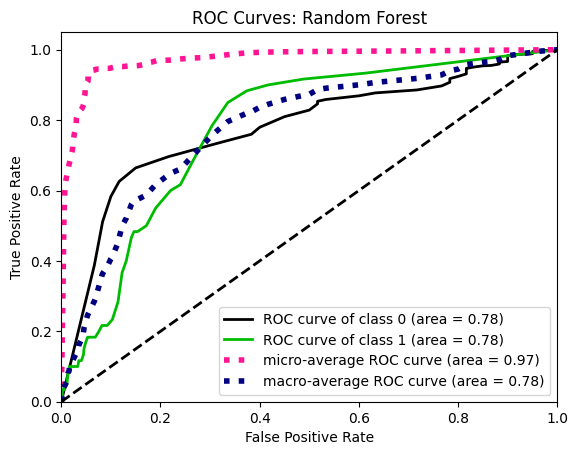

 
Model:  Linear Discriminant Analyzer
Validation Accuracy:  0.7299412915851272
Training Accuracy:  0.7813036020583191
 


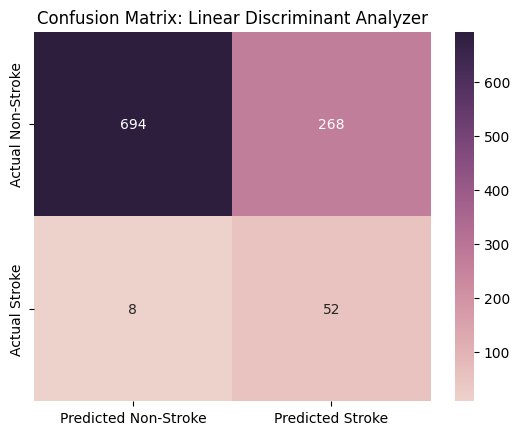

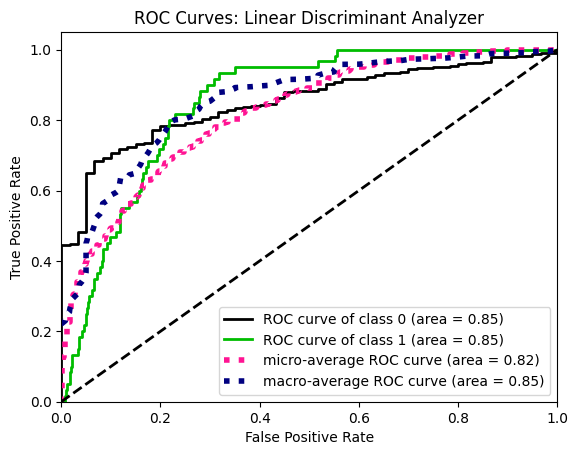

/home/blackitalian/miniconda3/envs/stroke/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


 
Model:  Ada Boost
Validation Accuracy:  0.9305283757338552
Training Accuracy:  0.9612349914236706
 


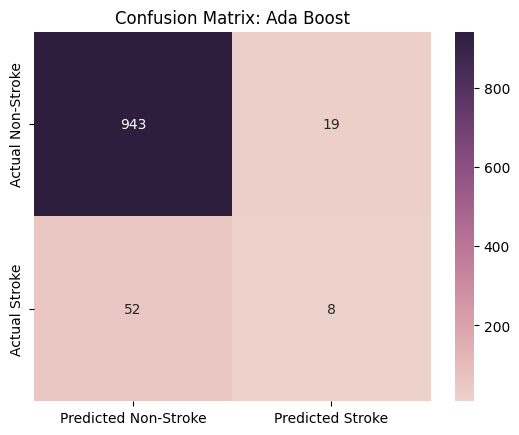

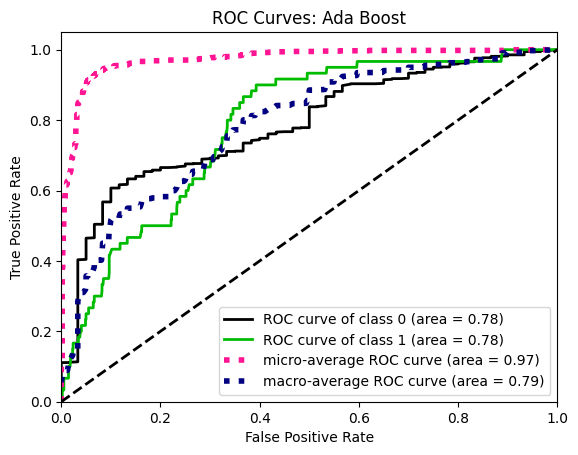

 
Model:  KNN
Validation Accuracy:  0.7837573385518591
Training Accuracy:  0.9188679245283019
 


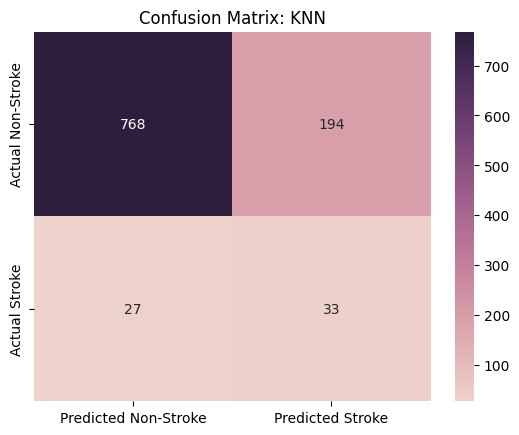

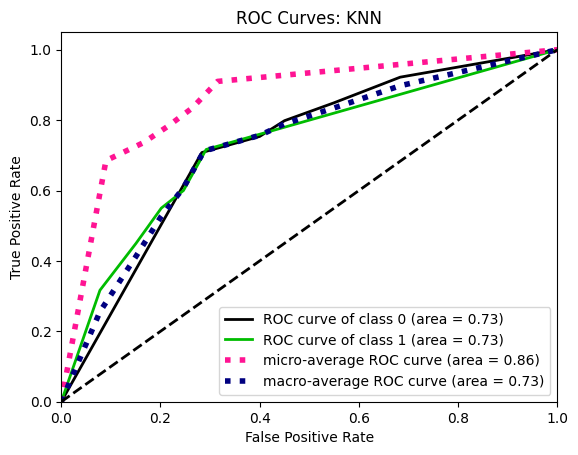

 
Model:  Support Vector Machine
Validation Accuracy:  0.700587084148728
Training Accuracy:  0.7656946826758148
 


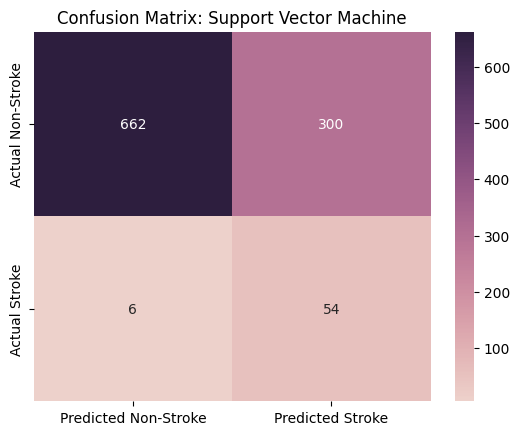

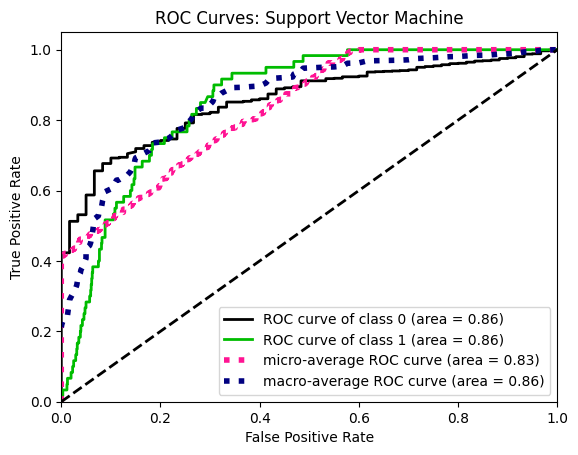

 
Model:  XG Boost
Validation Accuracy:  0.9393346379647749
Training Accuracy:  1.0
 


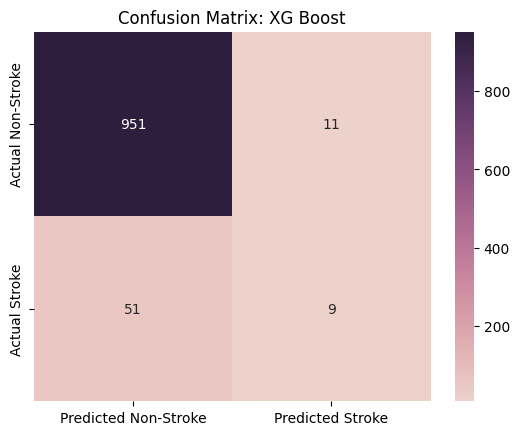

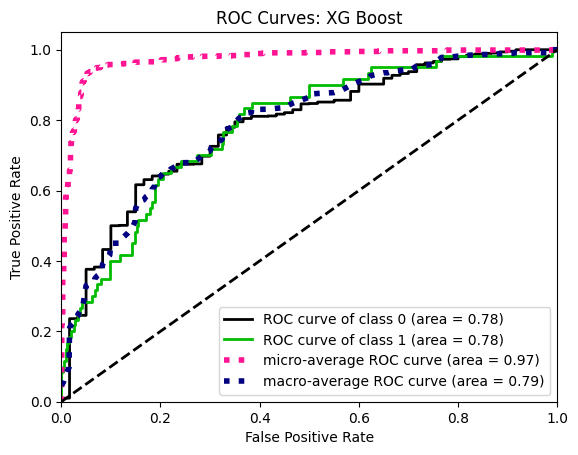

 
Model:  Cat Boost
Validation Accuracy:  0.9442270058708415
Training Accuracy:  0.9919382504288164
 


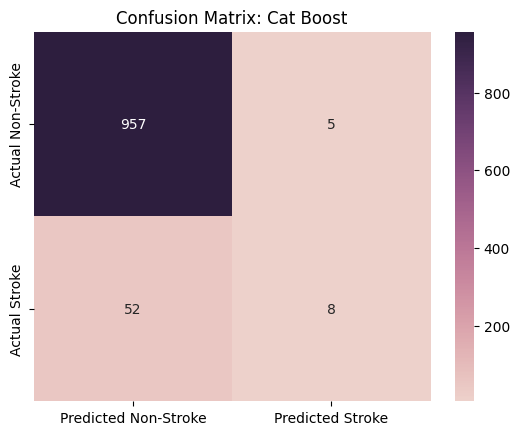

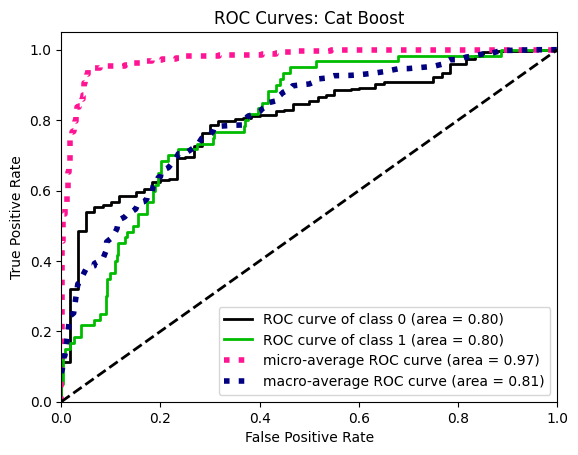

 
Model:  Naive Bayes
Validation Accuracy:  0.6428571428571429
Training Accuracy:  0.7024013722126929
 


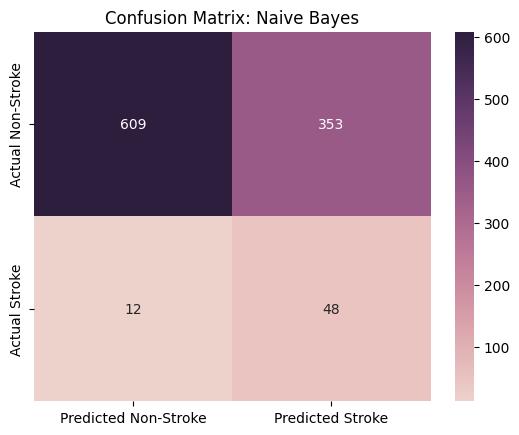

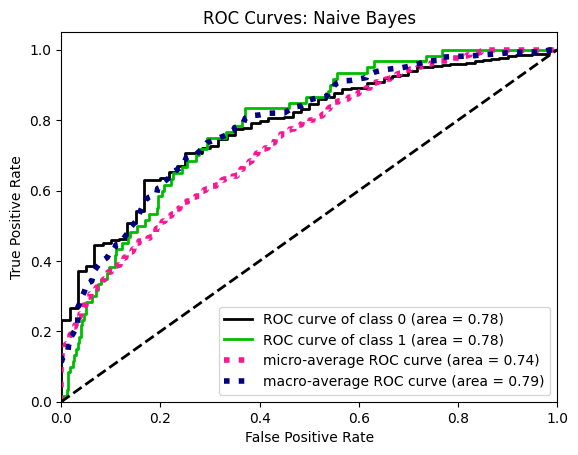

In [22]:
# Run all models
model_run(start_models,x_train_smt,y_train_smt,x_val,y_val)

#### SMOTE DF2 all models

 
Model:  Logistic Regression
Validation Accuracy:  0.7407045009784736
Training Accuracy:  0.7819897084048028
 


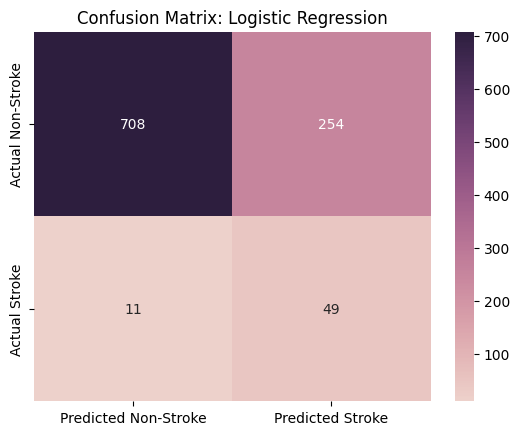

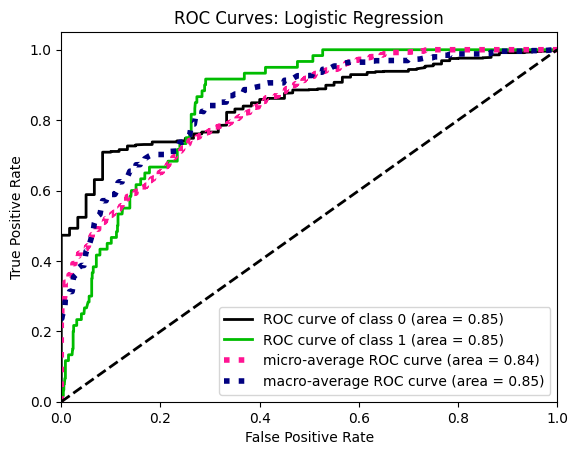

 
Model:  Decision Tree Classifier
Validation Accuracy:  0.87279843444227
Training Accuracy:  0.9972555746140652
 


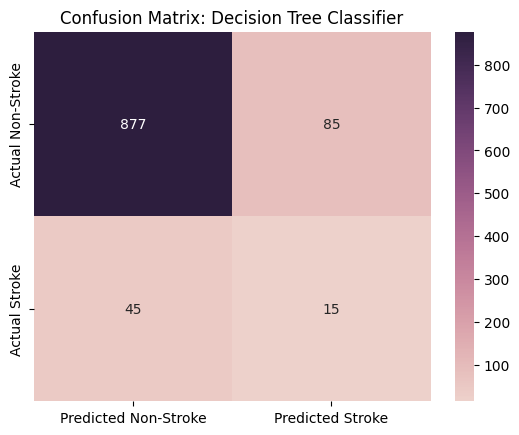

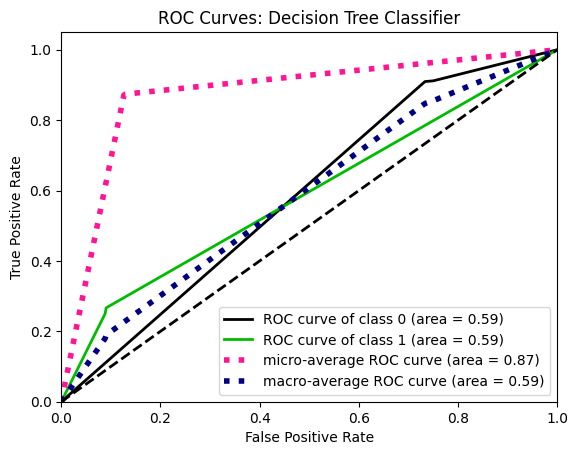

 
Model:  Random Forest
Validation Accuracy:  0.9363992172211351
Training Accuracy:  0.9972555746140652
 


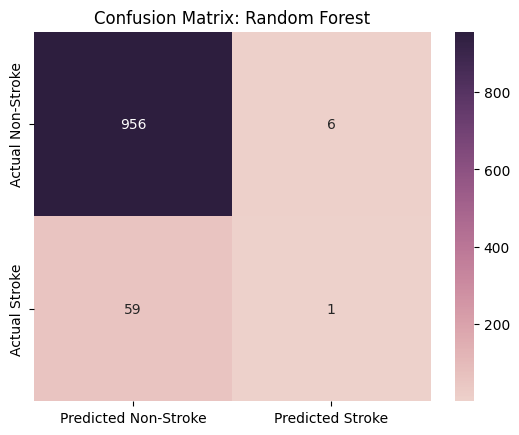

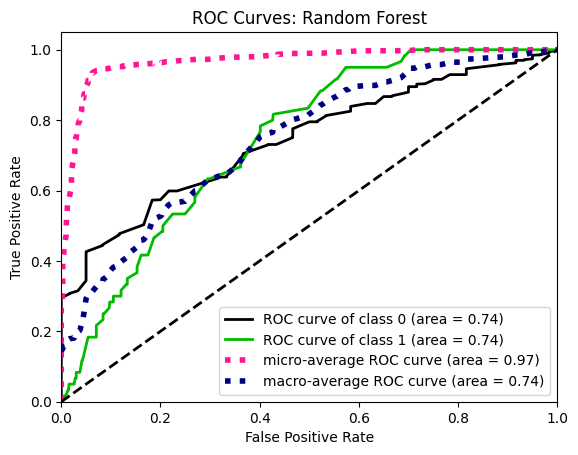

 
Model:  Linear Discriminant Analyzer
Validation Accuracy:  0.7142857142857143
Training Accuracy:  0.7828473413379073
 


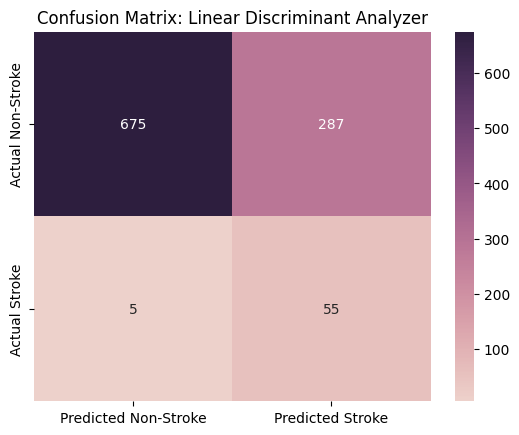

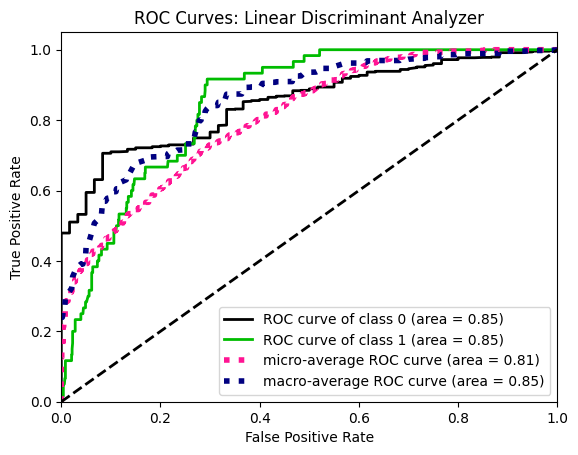

/home/blackitalian/miniconda3/envs/stroke/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


 
Model:  Ada Boost
Validation Accuracy:  0.7798434442270059
Training Accuracy:  0.9560891938250429
 


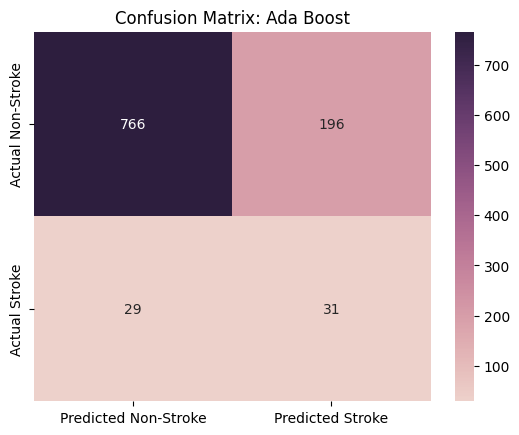

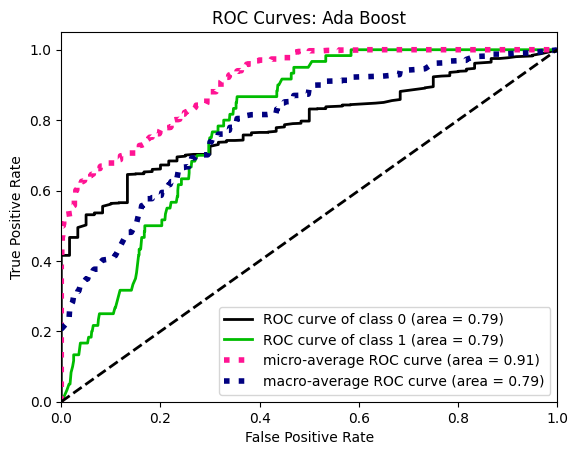

 
Model:  KNN
Validation Accuracy:  0.7798434442270059
Training Accuracy:  0.9298456260720411
 


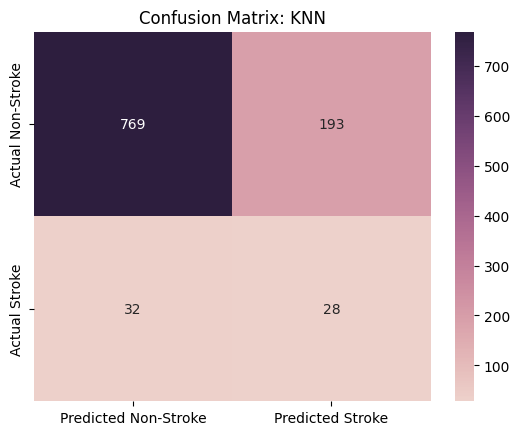

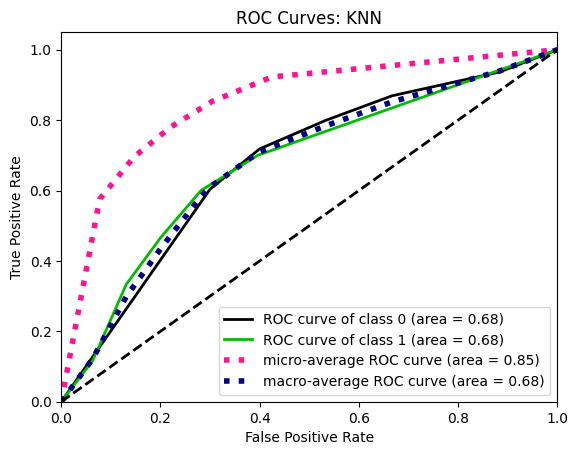

 
Model:  Support Vector Machine
Validation Accuracy:  0.6692759295499021
Training Accuracy:  0.7638078902229846
 


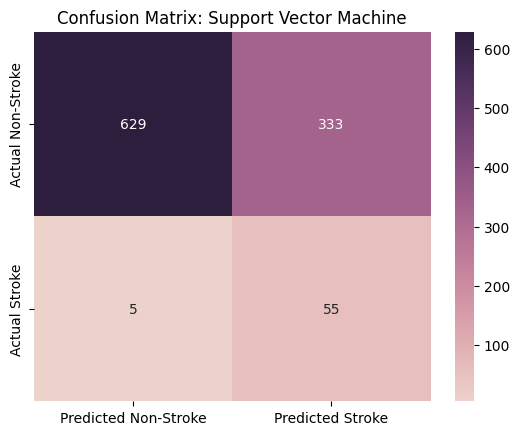

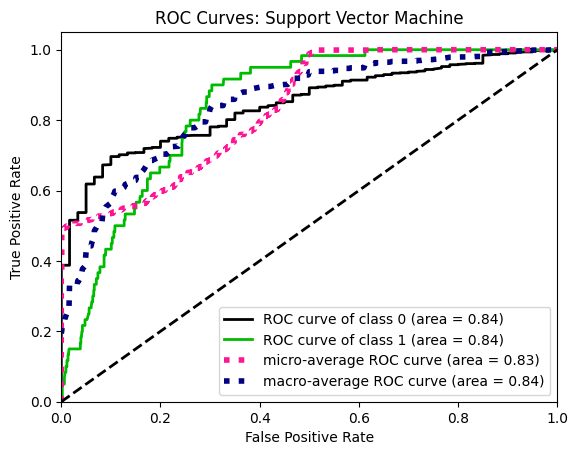

 
Model:  XG Boost
Validation Accuracy:  0.8943248532289628
Training Accuracy:  0.9890222984562608
 


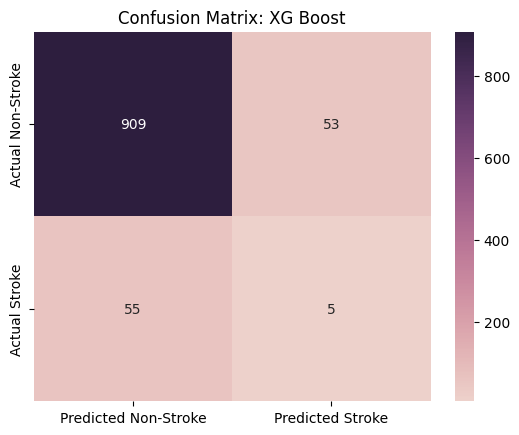

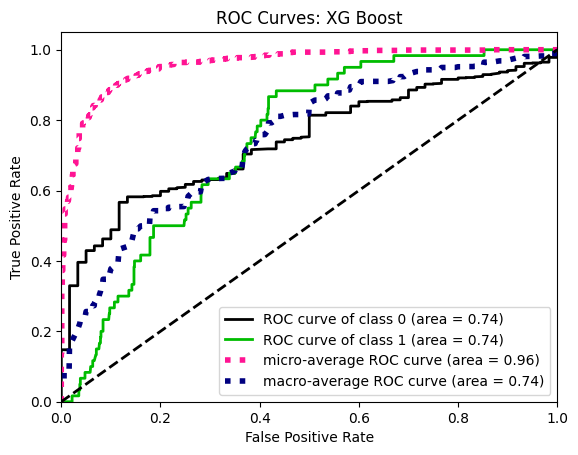

 
Model:  Cat Boost
Validation Accuracy:  0.9217221135029354
Training Accuracy:  0.9838765008576329
 


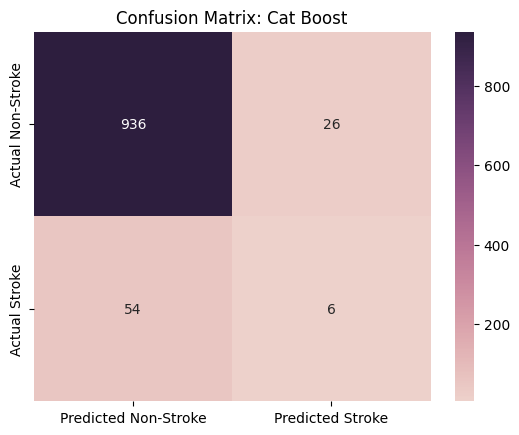

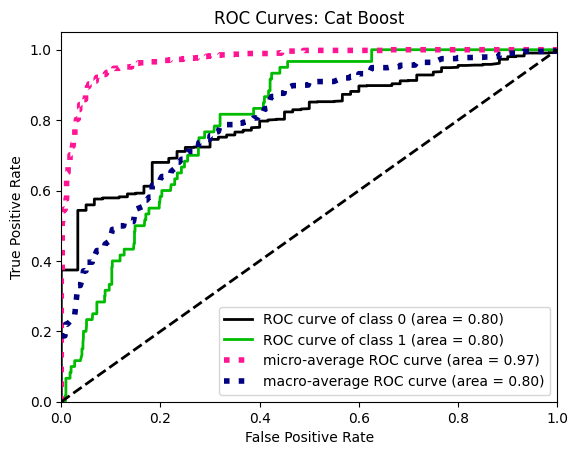

 
Model:  Naive Bayes
Validation Accuracy:  0.49706457925636005
Training Accuracy:  0.7332761578044596
 


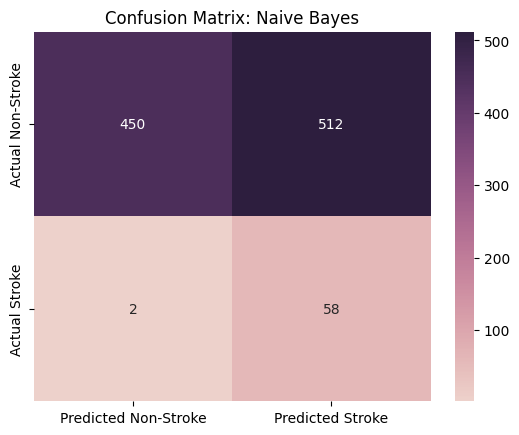

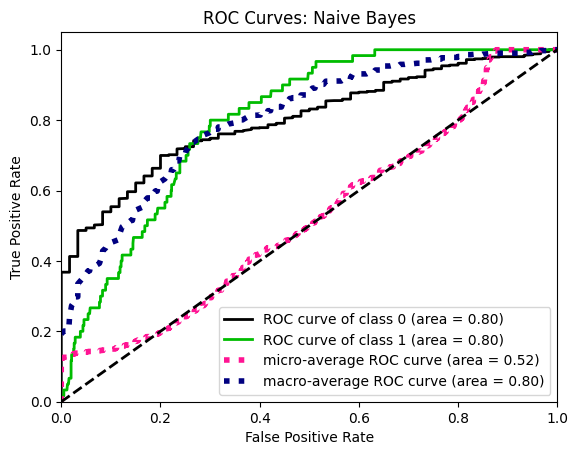

In [23]:
# Run all models 2
model_run(start_models,x_train2_smt,y_train2_smt,x_val2,y_val2)

Linear Discriminant Analyzer, Support Vector Machine, and Naive Bayes are best performers with positive stroke prediction being priority measurement.

## Best Performing Models

While the score may not be the highest, these models were the best at predicting a stroke. The trade off is lower non-stroke accuracy. In the case of healthcare, we would rather over capture non-stroke than miss actual strokes.

The df2 (more generalized data) and the SMOTE data increased accuracy.

Naive Bayes had the best Stroke positive prediction but the non-stroke prediction was so poor I am not sure that it is usable in production.

In [24]:
#@title Selected Models
best_models = [
            ('Logistic Regression', LogisticRegression(max_iter=4000,random_state=10)),
            ('Linear Discriminant Analyzer', LinearDiscriminantAnalysis()),
            ('Support Vector Machine', SVC(probability = True,random_state=10)),
            ('Naive Bayes', ComplementNB())
            ]

 
Model:  Logistic Regression
Validation Accuracy:  0.7407045009784736
Training Accuracy:  0.7819897084048028
 


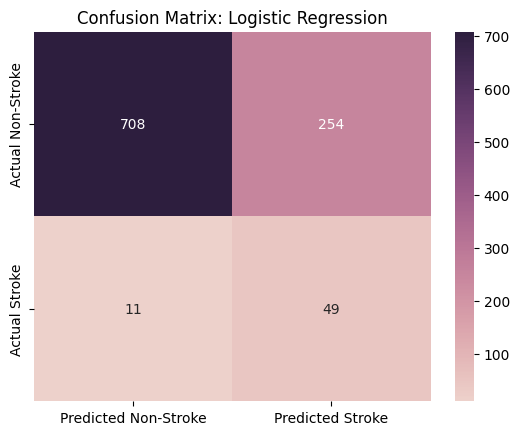

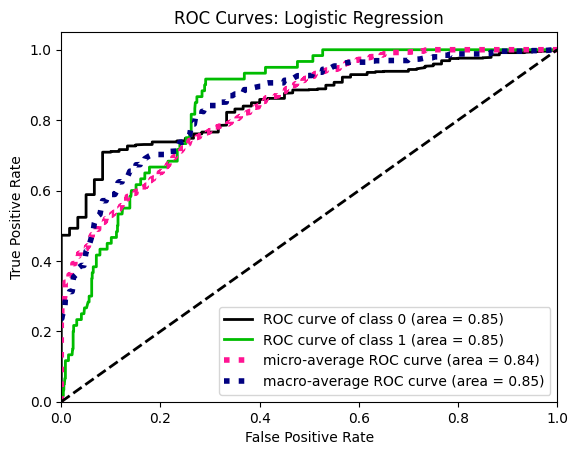

 
Model:  Linear Discriminant Analyzer
Validation Accuracy:  0.7142857142857143
Training Accuracy:  0.7828473413379073
 


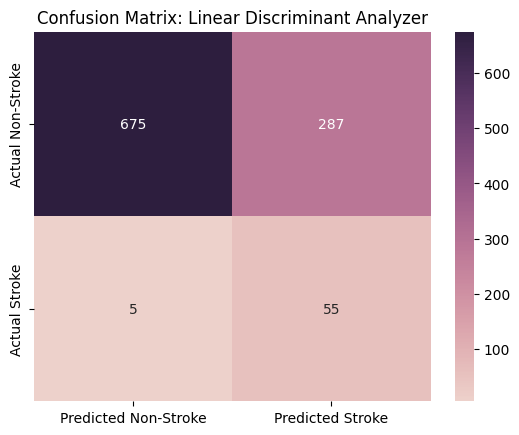

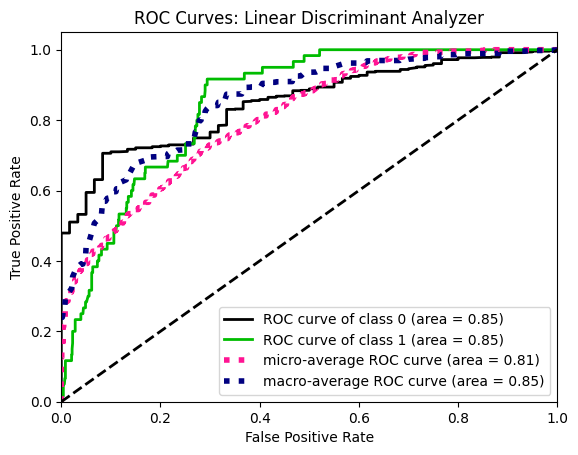

 
Model:  Support Vector Machine
Validation Accuracy:  0.6692759295499021
Training Accuracy:  0.7638078902229846
 


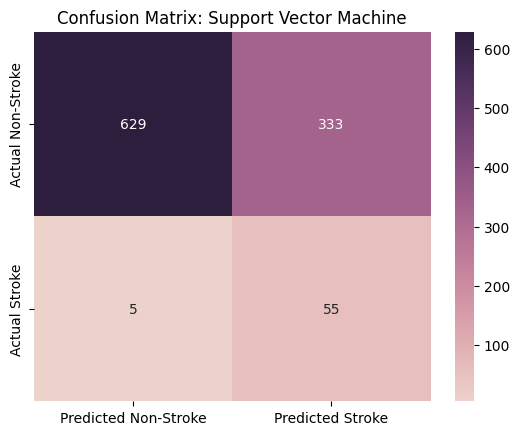

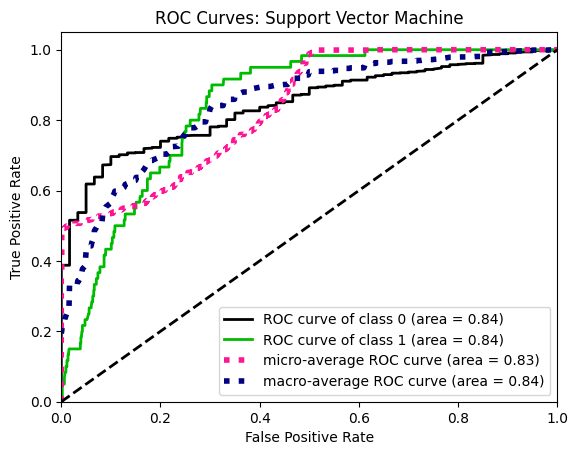

 
Model:  Naive Bayes
Validation Accuracy:  0.49706457925636005
Training Accuracy:  0.7332761578044596
 


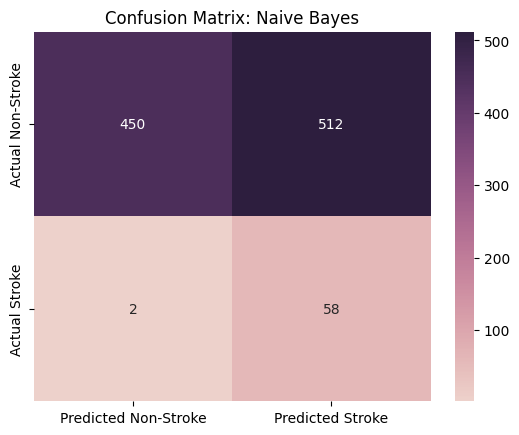

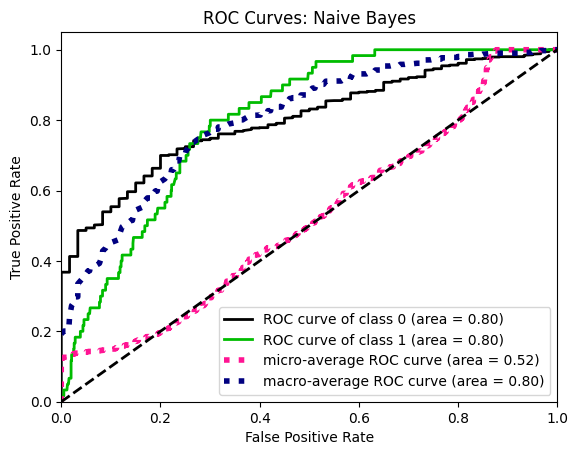

In [25]:
model_run(best_models, x_train2_smt,y_train2_smt,x_val2,y_val2)

<a name="tuning"></a>
# Tuning

The tuning process consists of adjusting and measuring model parameters, and, if needed, revisiting feature engineering.

<a name="feat_imp"></a>
## Feature Importance - [article](https://machinelearningmastery.com/calculate-feature-importance-with-python/)

## Feature Importance Model

In [26]:
my_list = [LinearDiscriminantAnalysis()]

In [27]:
# Feature Rank
for model in my_list:
    rfe = RFECV(estimator=model,step=1,cv=5)
    rfe.fit(x_train2_smt,y_train2_smt)
    print(" ")
    print(model)
    print(" ")
    for j, col, in zip(range(df.shape[1]), df.columns):
      print(f'{col} selected= {rfe.support_[1]} rank= {rfe.ranking_[1]}')

 
LinearDiscriminantAnalysis()
 
gender selected= True rank= 1
age selected= True rank= 1
hypertension selected= True rank= 1
heart_disease selected= True rank= 1
ever_married selected= True rank= 1
work_type selected= True rank= 1
residence_type selected= True rank= 1
avg_glucose_level selected= True rank= 1
bmi selected= True rank= 1
smoking_status selected= True rank= 1
stroke selected= True rank= 1


None of the features show a higher rank than the others.

In [28]:
#@title Get Feature Names

feat_names = dv.get_feature_names_out()

In [29]:
# def feature_importance(model)
def feature_importance(model):
    # define the model
    model = model
    # fit the model
    model.fit(x_train2_smt, y_train2_smt)
    # get importance
    importance = model.coef_[0]
    # summarize feature importance
    for i,v in enumerate(importance):
        print(f'Feature: {feat_names[i]}',' ',f'Score: {v}\n')

In [30]:
# Linear Discriminant Feature coefficients

feature_importance(LinearDiscriminantAnalysis())

# plot feature importance
#pyplot.bar([x for x in range(len(importance))], importance)
#pyplot.show()

Feature: age   Score: 0.09416599351883312

Feature: diabetes   Score: 0.7326272125405726

Feature: ever_married=No   Score: 0.09322360428219761

Feature: ever_married=Yes   Score: -0.09322360428219667

Feature: gender=Female   Score: 0.143563344010698

Feature: gender=Male   Score: -0.1435633440106986

Feature: heart_disease   Score: 0.37287806105916105

Feature: hypertension   Score: 0.29084317232972556

Feature: obese   Score: -0.24806603991597045

Feature: residence_type=Rural   Score: -0.09420214684826046

Feature: residence_type=Urban   Score: 0.09420214684826046

Feature: smoking_status=Unknown   Score: 0.029563013350875415

Feature: smoking_status=formerly smoked   Score: 0.20321155349508185

Feature: smoking_status=never smoked   Score: -0.20188758809078963

Feature: smoking_status=smokes   Score: 0.06803163540613136

Feature: work_type=Govt_job   Score: -0.590050441500511

Feature: work_type=Never_worked   Score: 0.5871497460487353

Feature: work_type=Private   Score: 0.138125

**NOTE:** Reading too much into coeficients can be dangerious as the relaitonships can be complex.

Heart_disease, Diabetes, and hypertension were all possitively correlated with stroke. This is consistent with studies showing that these diseases greatly increase your likelihood of having a stroke. [Cardiovascular risk factors](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4419105/) / [Diabetes and Stroke: Epidemiology, Pathophysiology, Pharmaceuticals and Outcomes](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5298897/#:~:text=Diabetes%20is%20a%20well%2Destablished,stroke%20with%20uncontrolled%20glucose%20levels.)

The second highest possitive coefficients is for work_type=children despte research showing that stroke in children is [rare](https://www.hopkinsmedicine.org/health/conditions-and-diseases/stroke/pediatric-stroke).

The obese feature may be confusing the models, as we are seeing inconsistent accounting for it, despite it being a known to increase the likelyhood of stroke. This may be a feature that is only positive when paired with other features. [Obesity and Stroke: Does the Paradox Apply for Stroke?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7946563/).

The negative coeficient for smokes (in logistic regression) is also intersting, as we know it leads to hypertension and heart disease. It is likely only positive when combined with hypertension and/or heart disease.

In [31]:
df2[df2.work_type == 'children'].stroke.value_counts()

stroke
0    685
1      2
Name: count, dtype: int64

It may be better to remove the children type and limit age to 18+; creating an adult only model. It is reasonable that children would need a model specific to them.

## Feature Importance Data

In [32]:
# Sample Stroke Rate
stroke_rate = df.stroke.mean() # works because it is binary
round(stroke_rate,2)

0.05

In [33]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          5109 non-null   object 
 1   age             5109 non-null   float64
 2   hypertension    5109 non-null   int64  
 3   heart_disease   5109 non-null   int64  
 4   ever_married    5109 non-null   object 
 5   work_type       5109 non-null   object 
 6   residence_type  5109 non-null   object 
 7   smoking_status  5109 non-null   object 
 8   stroke          5109 non-null   int64  
 9   obese           5109 non-null   bool   
 10  diabetes        5109 non-null   bool   
dtypes: bool(2), float64(1), int64(3), object(5)
memory usage: 369.3+ KB


In [34]:
categorical = ['gender','hypertension','heart_disease','ever_married','work_type','residence_type','smoking_status','obese','diabetes']

In [35]:
# Feature Importance Breakdown

for c in categorical:
    print(c)
    df_group = df2.groupby(c).stroke.agg(['mean','count'])
    df_group['diff'] = df_group['mean'] - stroke_rate # difference between group and overall stroke rate
    df_group['risk'] = df_group['mean'] / stroke_rate # group risk relative to overall risk
    display(df_group)
    print('\n')

gender


mean  count      diff      risk
gender                                     
Female  0.047094   2994 -0.001643  0.966282
Male    0.051064   2115  0.002326  1.047731



hypertension


mean  count      diff      risk
hypertension                                     
0             0.039688   4611 -0.009050  0.814315
1             0.132530    498  0.083793  2.719263



heart_disease


mean  count      diff      risk
heart_disease                                     
0              0.041796   4833 -0.006942  0.857573
1              0.170290    276  0.121552  3.494020



ever_married


mean  count      diff      risk
ever_married                                     
No            0.016515   1756 -0.032223  0.338852
Yes           0.065613   3353  0.016875  1.346250



work_type


mean  count      diff      risk
work_type                                         
Govt_job       0.050228    657  0.001491  1.030588
Never_worked   0.000000     22 -0.048738  0.000000
Private        0.050958   2924  0.002220  1.045552
Self-employed  0.079365    819  0.030628  1.628418
children       0.002911    687 -0.045826  0.059732



residence_type


mean  count      diff      risk
residence_type                                     
Rural           0.045364   2513 -0.003373  0.930784
Urban           0.052003   2596  0.003266  1.067003



smoking_status


mean  count      diff      risk
smoking_status                                      
Unknown          0.030440   1544 -0.018297  0.624579
formerly smoked  0.079186    884  0.030448  1.624734
never smoked     0.047569   1892 -0.001169  0.976018
smokes           0.053232    789  0.004494  1.092217



obese


mean  count      diff      risk
obese                                     
False  0.047350   3189 -0.001387  0.971536
True   0.051042   1920  0.002304  1.047277



diabetes


mean  count      diff      risk
diabetes                                     
False     0.036372   4289 -0.012365  0.746286
True      0.113415    820  0.064677  2.327050

The most most interesting thing here is we can see that the stroke risk relative to the group risk is consistent with expectations.

In [36]:
def mutual_stroke(series):
    return mutual_info_score(series,df2['stroke'])

In [37]:
mi = df2[categorical].apply(mutual_stroke)
mi.sort_values(ascending=False)

ever_married      0.006945
diabetes          0.006867
work_type         0.006827
hypertension      0.005975
heart_disease     0.005897
smoking_status    0.002757
residence_type    0.000119
gender            0.000041
obese             0.000034
dtype: float64

We can see that the categories are independant, this is expected.

## Feature Importance Testing




**Hypothesis:** better prediction can be obtained by excluding children value.

In [38]:
df2_adult = df2.copy()

In [39]:
age18 = df2[(df['age']<18)].index
df2_adult = df2_adult.drop(age18)

<Axes: ylabel='Frequency'>

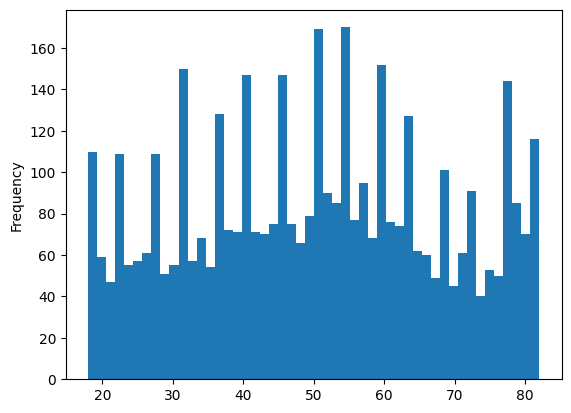

In [40]:
df2_adult.age.plot.hist(bins=50)

In [41]:
#@title Split: x_train2_adult / x_val2_adult / x_test2_adult

df2_full_train_adult, x_val2_adult = train_test_split(df2_adult, test_size=0.2, random_state=1)
x_train2_adult, x_test2_adult = train_test_split(df2_full_train_adult, test_size=0.25, random_state=1)

x_train2_adult = x_train2_adult.reset_index(drop=True)
x_val2_adult = x_val2_adult.reset_index(drop=True)
x_test2_adult = x_test2_adult.reset_index(drop=True)

y_train2_adult = x_train2_adult.stroke.values
y_val2_adult = x_val2_adult.stroke.values
y_test2_adult = x_test2_adult.stroke.values

del x_train2_adult['stroke']
del x_val2_adult['stroke']
del x_test2_adult['stroke']

dv = DictVectorizer(sparse=False)

# df2_train_child
df2_train2_dict_adult = x_train2_adult.to_dict(orient='records')
x_train2_adult = dv.fit_transform(df2_train2_dict_adult)

# df2_x_val_adult
df2_val2_dict_adult = x_val2_adult.to_dict(orient='records')
x_val2_adult = dv.transform(df2_val2_dict_adult)

# x_test2_adult
df2_test2_dict_adult = x_test2_adult.to_dict(orient='records')
x_test2_adult = dv.transform(df2_test2_dict_adult)

In [42]:
x_train2_adult_smt, y_train2_adult_smt = training_smote(x_train2_adult, y_train2_adult)

 
Model:  Logistic Regression
Validation Accuracy:  0.7215041128084606
Training Accuracy:  0.7371392722710163
 


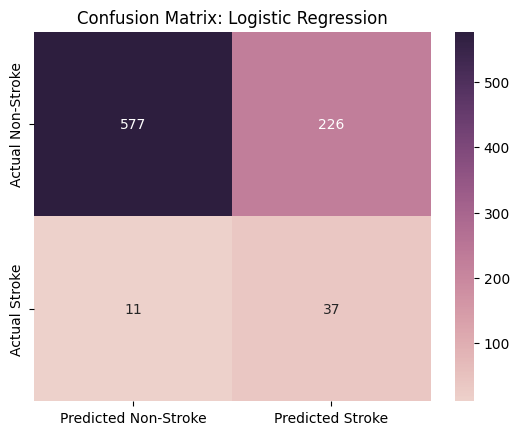

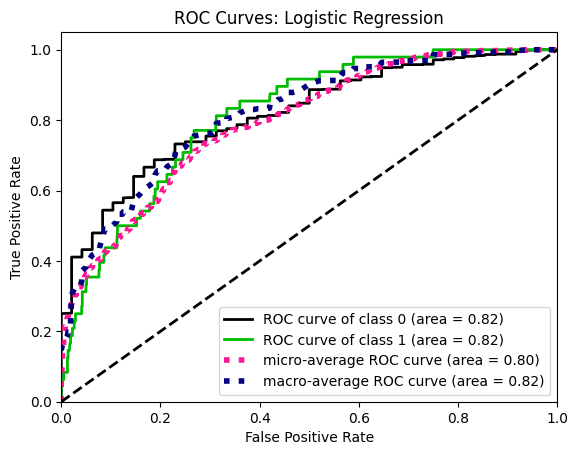

 
Model:  Linear Discriminant Analyzer
Validation Accuracy:  0.7121034077555817
Training Accuracy:  0.7371392722710163
 


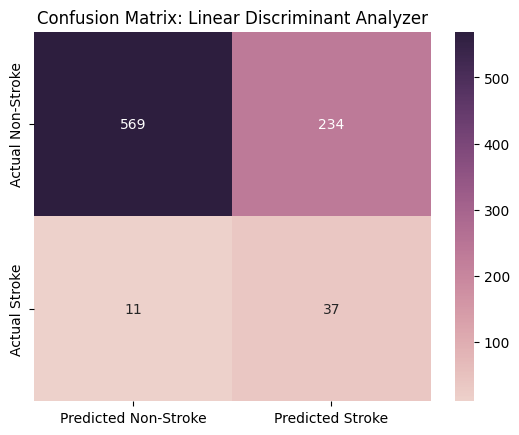

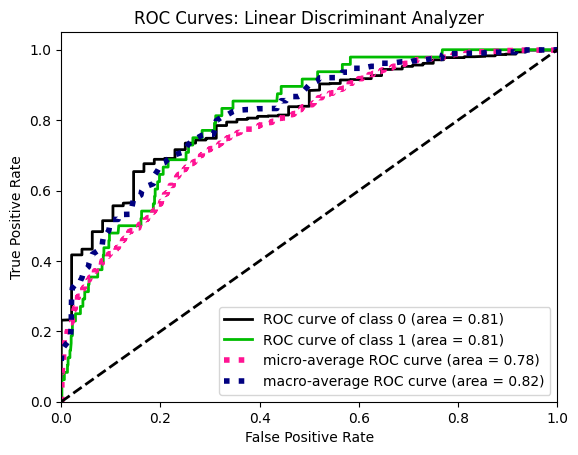

 
Model:  Support Vector Machine
Validation Accuracy:  0.600470035252644
Training Accuracy:  0.726474278544542
 


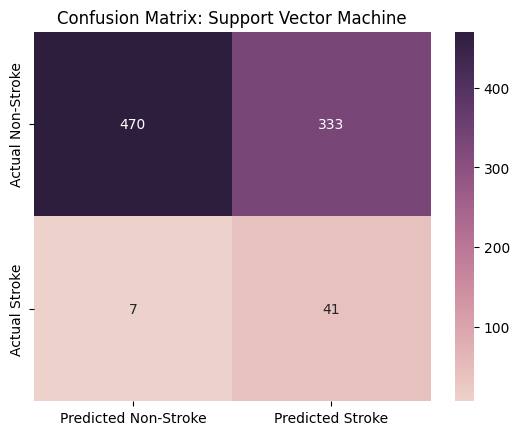

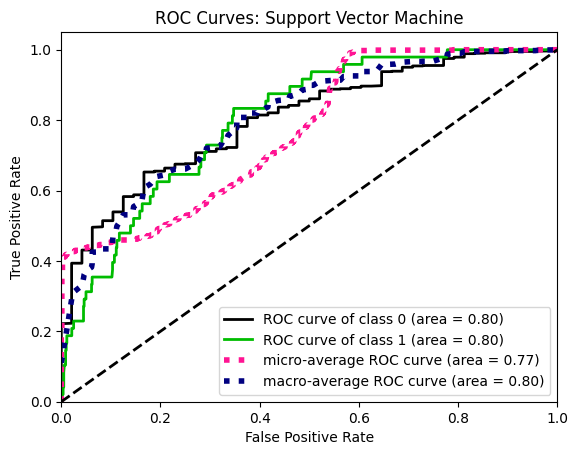

 
Model:  Naive Bayes
Validation Accuracy:  0.6862514688601645
Training Accuracy:  0.7078628189042242
 


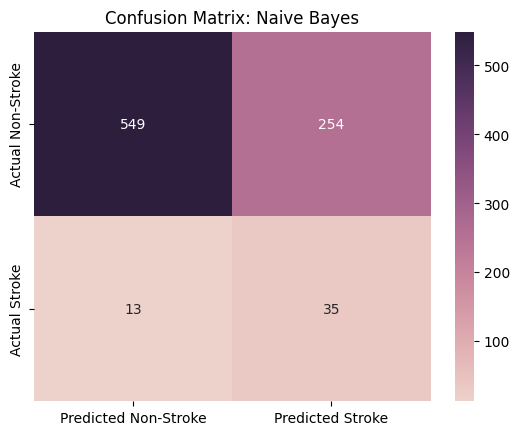

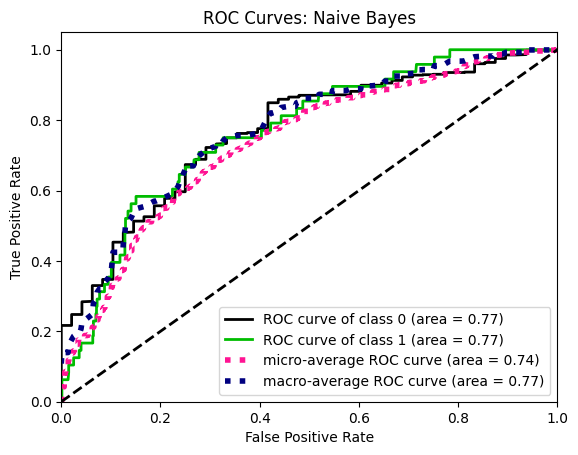

In [43]:
# selected_models is defined at the end of the section Modeling
model_run(best_models,x_train2_adult_smt, y_train2_adult_smt,x_val2_adult,y_val2_adult)

All models did worse. Removing children had a negative affect.

<a name="modTune"></a>
## Model Tuning

### LogisticRegression Tunning
[Article](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/)

In [44]:
log_model = LogisticRegression(max_iter=4000, random_state=10)

In [45]:
# define LogisticRegression and parameters
model = log_model
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01,0.001]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=10)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train2, y_train2) # defined in the modeling section
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.951060 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.950843 (0.001173) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.950951 (0.001037) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.950951 (0.001037) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.950951 (0.001037) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.950951 (0.001037) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.950951 (0.001037) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.950951 (0.001037) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.950951 (0.001037) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.951060 (0.000866) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.951060 (0.000080) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.951060 (0.000080) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.951060 (0.000080) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.951060 (0.000080) wit

As noted previously, we need possitive stroke prediction first and model statistics second. Using the above results gives us a guidline to test against but it is limited in that is looing at model performace and not taking into account possitive stroke prediction.

In [46]:
# Final model comparison
log_model_opt = [('liblinear', LogisticRegression(max_iter=4000, random_state=10,C=0.1,penalty='l2',solver='liblinear')),
                 ('newton-cg', LogisticRegression(max_iter=4000, random_state=10,C=0.1,penalty='l2',solver='newton-cg')),
                 ('lbfgs', LogisticRegression(max_iter=4000, random_state=10,C=0.1,penalty='l2',solver='lbfgs')),
                 ('Default', LogisticRegression(max_iter=4000, random_state=10))]

 
Model:  liblinear
Validation Accuracy:  0.684931506849315
Training Accuracy:  0.7821612349914236
 


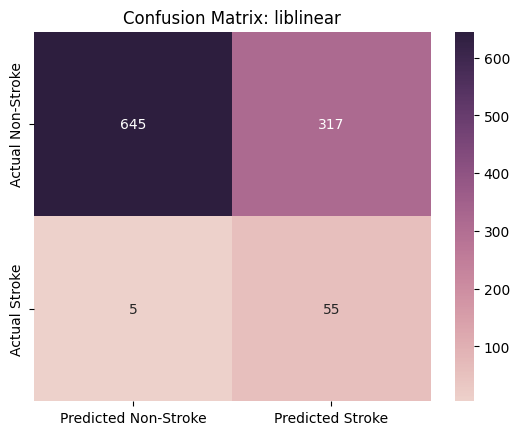

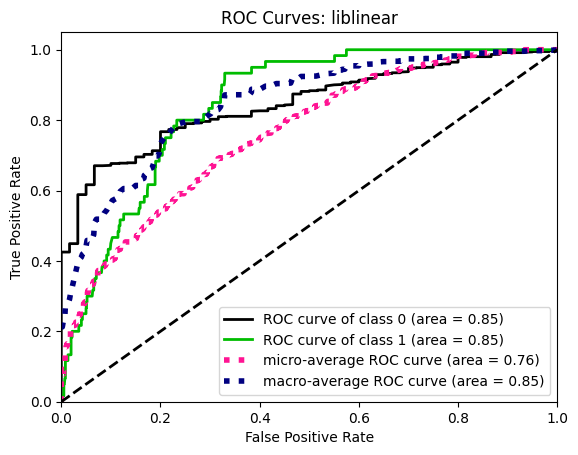

 
Model:  newton-cg
Validation Accuracy:  0.7377690802348337
Training Accuracy:  0.7821612349914236
 


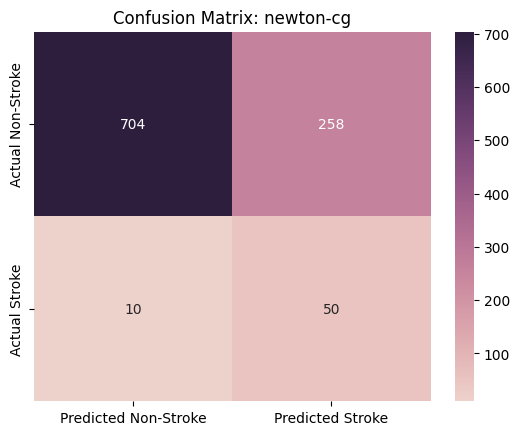

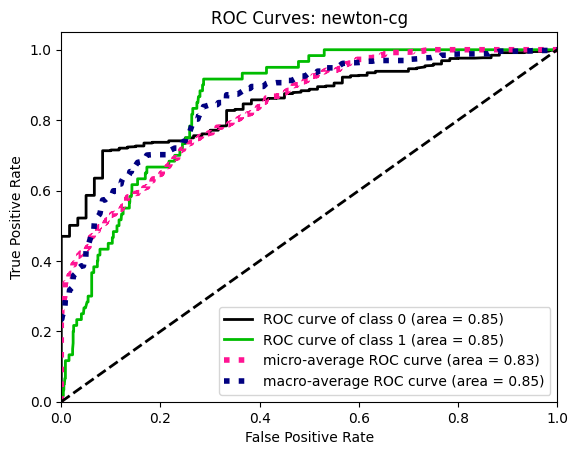

 
Model:  lbfgs
Validation Accuracy:  0.7377690802348337
Training Accuracy:  0.7819897084048028
 


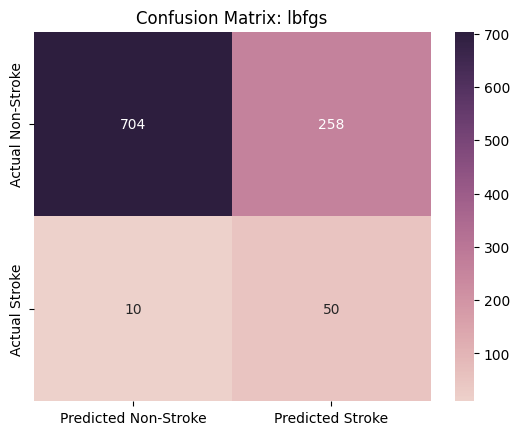

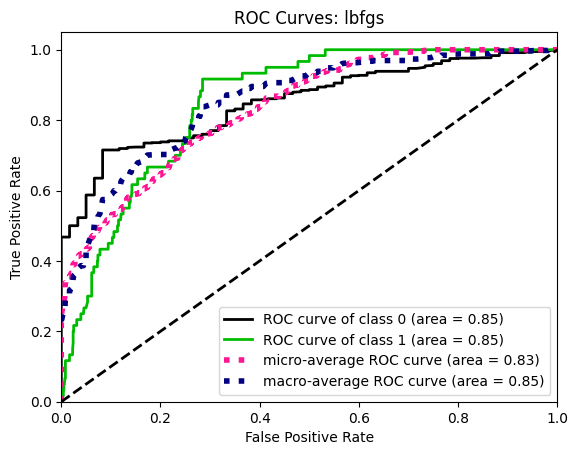

 
Model:  Default
Validation Accuracy:  0.7407045009784736
Training Accuracy:  0.7819897084048028
 


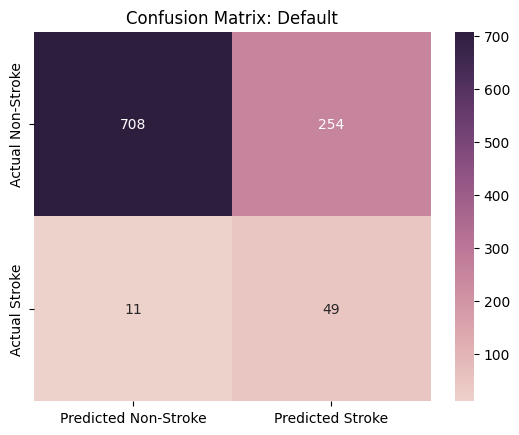

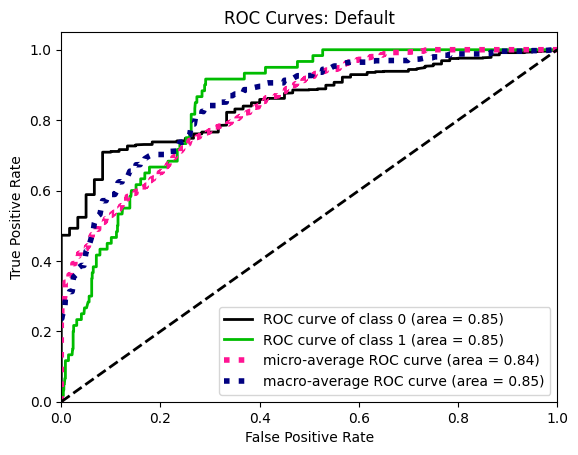

In [47]:
model_run(log_model_opt,x_train2_smt,y_train2_smt,x_val2,y_val2)

**Logistic Regression**, `LogisticRegression(max_iter=4000, random_state=10,C=0.1,penalty='l2',solver='liblinear')` is the best performing.

In [48]:
# Optimized Log Model

log_model = LogisticRegression(max_iter=4000, random_state=10,C=0.1,penalty='l2',solver='liblinear')

### LinearDiscriminantAnalysis Tuning
[Article](https://machinelearningmastery.com/linear-discriminant-analysis-for-machine-learning/)

In [49]:
lda_models = [('svd', LinearDiscriminantAnalysis(solver='svd')),
          ('lsqr', LinearDiscriminantAnalysis(solver='lsqr')),
          ('eigen', LinearDiscriminantAnalysis(shrinkage='auto',solver='eigen'))]

 
Model:  svd
Validation Accuracy:  0.7142857142857143
Training Accuracy:  0.7828473413379073
 


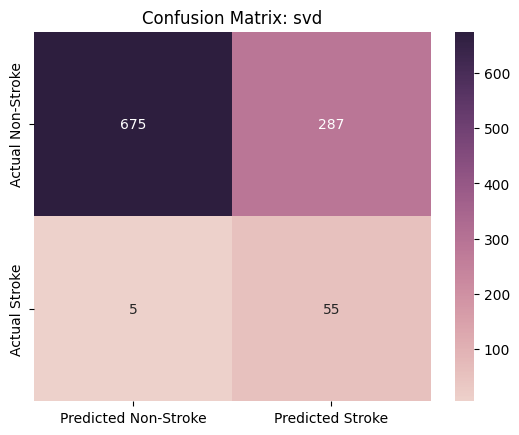

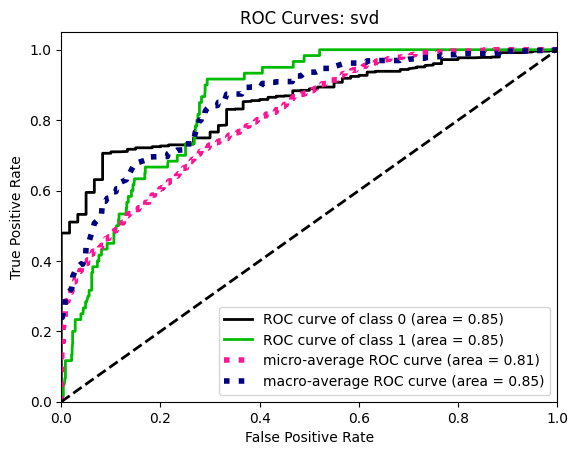

 
Model:  lsqr
Validation Accuracy:  0.7142857142857143
Training Accuracy:  0.7828473413379073
 


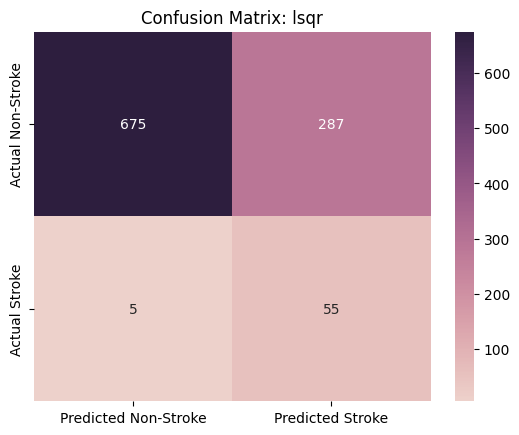

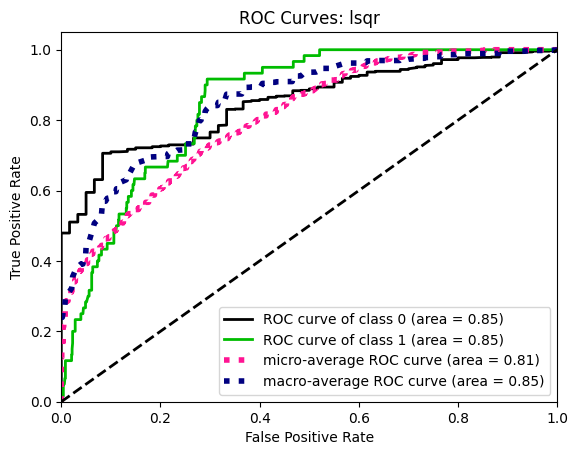

 
Model:  eigen
Validation Accuracy:  0.713307240704501
Training Accuracy:  0.7833619210977701
 


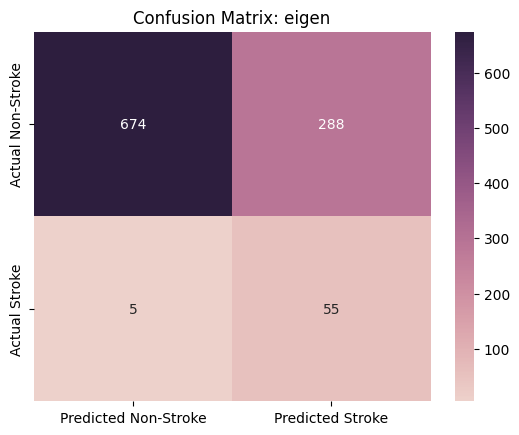

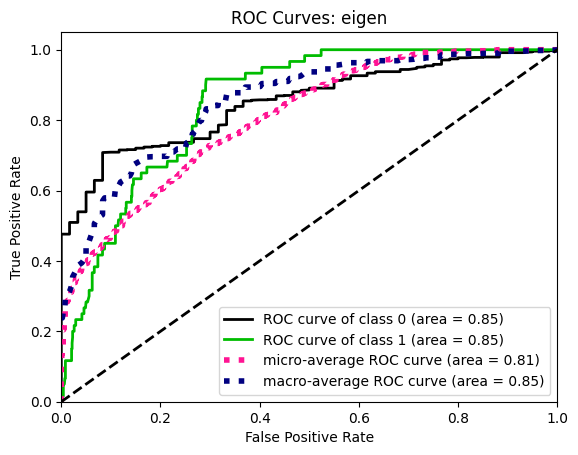

In [50]:
model_run(lda_models,x_train2_smt,y_train2_smt,x_val2,y_val2)

The Model `LinearDiscriminantAnalysis(solver='svd')` outperfomred Logistic Regression models.

In [51]:
lda_model = LinearDiscriminantAnalysis(solver='svd')

### SVM Tuning

#### SVM hyperparamerts tuning using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [52]:
# baseline
# train the model on train set
model =  SVC(probability = True,random_state=10)
model.fit(x_train2_smt, y_train2_smt)

# print prediction results
predictions = model.predict(x_val)
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       962
           1       0.09      0.12      0.10        60

    accuracy                           0.88      1022
   macro avg       0.52      0.52      0.52      1022
weighted avg       0.89      0.88      0.88      1022



In [53]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.951 total time=   0.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.951 total time=   0.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.951 total time=   0.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.951 total time=   0.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.951 total time=   0.4s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.951 total time=   0.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.951 total time=   0.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.951 total time=   0.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.951 total time=   0.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.951 total time=   0.2s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.951 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [54]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=0.1, gamma=1)


In [55]:
grid_predictions = grid.predict(x_train2_smt)

# print classification report
print(classification_report(y_train2_smt, grid_predictions))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2915
           1       0.00      0.00      0.00      2915

    accuracy                           0.50      5830
   macro avg       0.25      0.50      0.33      5830
weighted avg       0.25      0.50      0.33      5830



/home/blackitalian/miniconda3/envs/stroke/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/blackitalian/miniconda3/envs/stroke/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/blackitalian/miniconda3/envs/stroke/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

 
Model:  rbf
Validation Accuracy:  0.9383561643835616
Training Accuracy:  0.9660377358490566
 


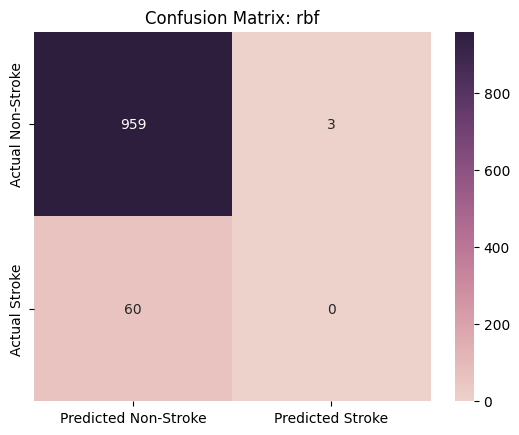

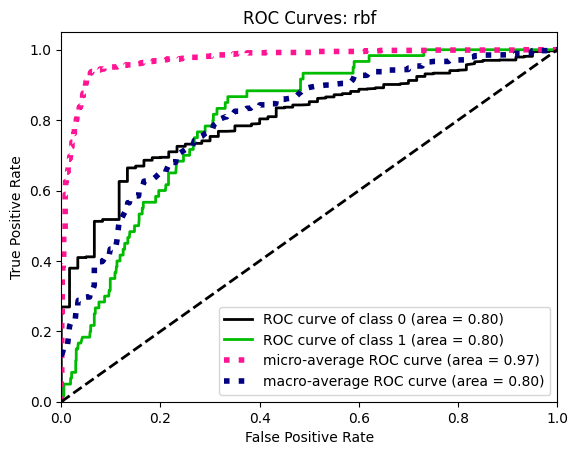

 
Model:  Default
Validation Accuracy:  0.6692759295499021
Training Accuracy:  0.7638078902229846
 


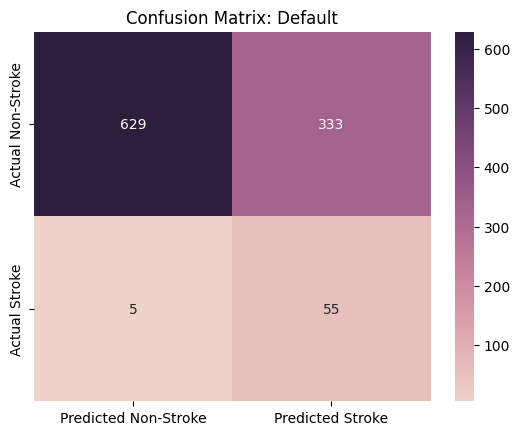

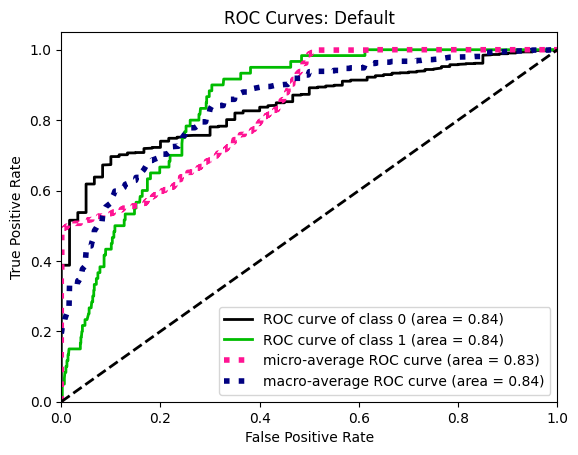

In [56]:
svc_models =[('rbf',SVC(kernel='rbf',probability = True,random_state=10,C=0.1,gamma=1)),('Default',SVC(probability = True,random_state=10))]
model_run(svc_models, x_train2_smt,y_train2_smt,x_val2,y_val2)

Tuning lead to overfitting and poor predictive accracy for stroke positive observations. Default svc is the better of the two.

Best overall model however is `lda_model = LinearDiscriminantAnalysis(solver='svd')`

### Final Model selection

In [57]:
final_model = [('lda_model', LinearDiscriminantAnalysis(solver='svd'))]

In [58]:
#@title def model_test(models)

def model_test(models):
  for name, model in models:
      model = model

      print(" ")
      print("Model: ",name)
      print('Testing Accuracy: ', accuracy_score(y_test2, model.predict(x_test2)))
      print(" ")

      plt.figure()
      cf_matrix = confusion_matrix(y_test2, model.predict(x_test2))
      plt.title('Confusion Matrix: {}'.format(name))
      sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
      plt.show()

      print(" ")

      skplt.metrics.plot_roc(y_test2, model.predict_proba(x_test2))
      plt.title('ROC Curves: {}'.format(name))
      plt.show()

 
Model:  lda_model
Validation Accuracy:  0.7142857142857143
Training Accuracy:  0.7828473413379073
 


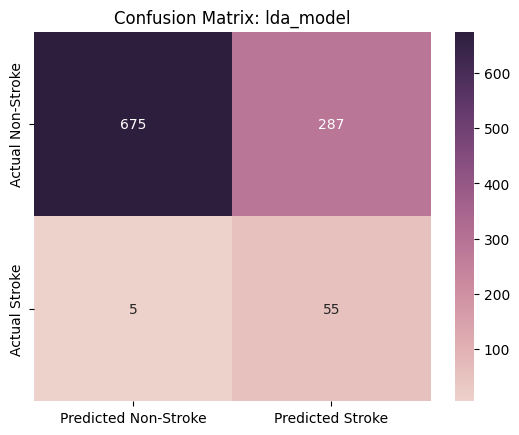

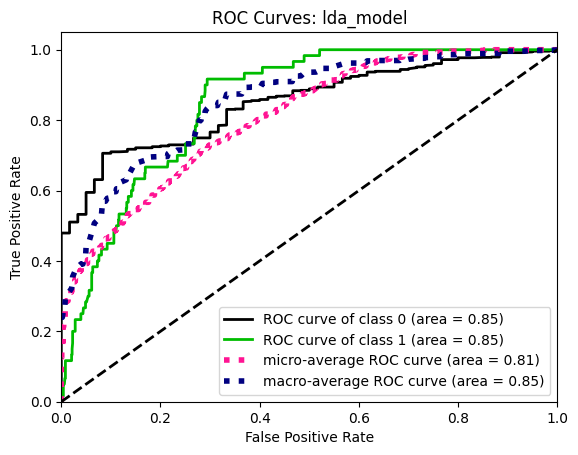

In [59]:
model_run(final_model,x_train2_smt,y_train2_smt,x_val2,y_val2)

 
Model:  lda_model
Testing Accuracy:  0.7299412915851272
 


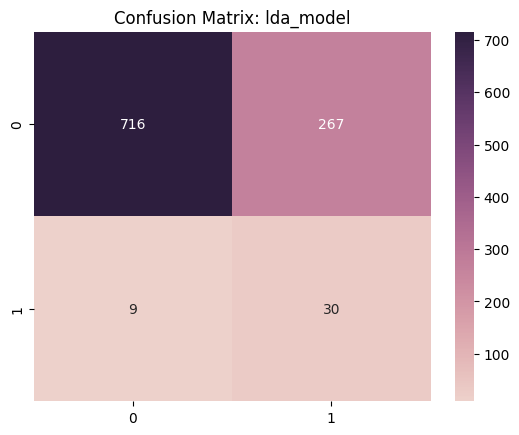

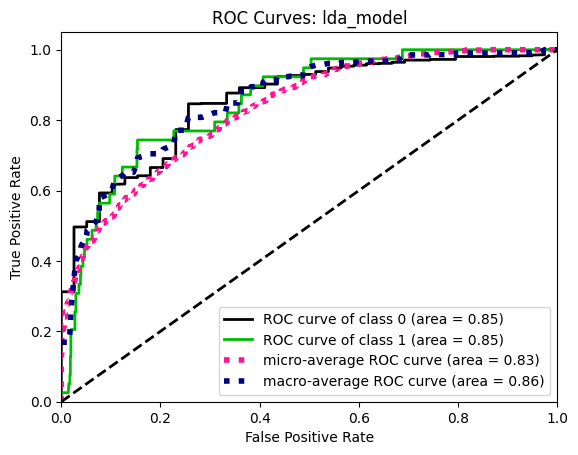

In [60]:
model_test(final_model)

<a name="deploy"></a>
# Deployment

**This is the code for creating the bento, cannot access service on Google Colab.**

## Data prep

## Model

In [61]:
df2.iloc[6] # is the index of a stroke positive patient

gender                    Male
age                       74.0
hypertension                 1
heart_disease                1
ever_married               Yes
work_type              Private
residence_type           Rural
smoking_status    never smoked
stroke                       1
obese                    False
diabetes                 False
Name: 6, dtype: object

**JSON format**
{
"gender": "Male",
"age": 74.0,
"hypertension": 1,
"heart_disease": 1,
"ever_married": Yes,
"work_type": "Private",
"residence_type": "Rural",
"smoking_status": "never smoked",
"obese": False,
"diabetes": False
}

In [62]:
model = LinearDiscriminantAnalysis(solver='svd')

In [63]:
model.fit(x_train2_smt, y_train2_smt)
y_pred = model.predict_proba(x_test2)

In [64]:
len(x_test2), len(y_pred)

(1022, 1022)

In [65]:
y_pred[6,1] # 6 is the index of a stroke positive patient, 1 is prediction probability

0.8501397942694416

<a name="bento"></a>
## Bentoml

In [71]:
df2.to_csv('./data/clean_stroke_data.csv', index=False)

In [67]:
%%writefile training.py

# Script to train and save model

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction import DictVectorizer
from imblearn.over_sampling import SMOTE
import bentoml


df = pd.read_csv('./data/clean_stroke_data.csv')

# data split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.stroke.values
y_test = df_test.stroke.values

del df_train['stroke']
del df_test['stroke']

# x_train
train_dict = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(train_dict)

# x_test
test_dict = df_test.to_dict(orient='records')
x_test = dv.transform(test_dict)

# ONLY APPLY SMOTE TO TRAIN!
def training_smote(x,y):
    smt = SMOTE(random_state=1)
    x_train, y_train = smt.fit_resample(x, y)
    return x_train, y_train

# SMOTE
x_train_smt, y_train_smt = training_smote(x_train, y_train)
len(x_train), len(y_train)

# Train model
model = LinearDiscriminantAnalysis(solver='svd')

model.fit(x_trai_smt, y_train_smt)

bentoml.sklearn.save_model('stroke_prediction', model,
                           custom_objects={
                               'dicVectorizer': dv
                           },
                           signatures = {"predict_proba": {"batchable": False}}
                           )

Overwriting training.py


**Save Model**

In [68]:
# save model from notebook
bentoml.sklearn.save_model('stroke_prediction', model,
                           custom_objects={
                               'dicVectorizer': dv
                           },
                           signatures = {"predict_proba": {"batchable": False}}
                           )

Model(tag="stroke_prediction:hzw4yyh3ropbuaav", path="/home/blackitalian/bentoml/models/stroke_prediction/hzw4yyh3ropbuaav/")

**service.py file, service that runs.**

[Risk Rates](https://www.betterhealth.vic.gov.au/health/conditionsandtreatments/heart-disease-and-stroke-your-risk-score)

Calculate a percentage score (or absolute risk), which puts you into one of three categories of risk:

* **High risk** – a score over 15% means you are at high risk. If you have a score over 15%, you have at least a 1 in 7 chance of having a heart attack or stroke in the next five years, if nothing is changed.
* **Moderate risk** – a score of between 10% and 15%, you have (as a minimum), a 1 in 10 chance of having a heart attack or stroke in the next five years, if nothing is changed.
* **Low risk** – a score under 10%, you have a less than 1 in 10 chance of having a heart attack or stroke in the next five years, if nothing is changed.

In [69]:
%%writefile service.py

import bentoml
from bentoml.io import JSON
import numpy as np

model_ref = bentoml.sklearn.get('stroke_prediction:latest')
dv = model_ref.custom_objects['dicVectorizer']

model_runner = model_ref.to_runner()

svc = bentoml.Service('stroke_prediction', runners=[model_runner])

@svc.api(input= JSON.from_sample({
      "gender": "Male",
      "age": 74.0,
      "hypertension": 1,
      "heart_disease": 1,
      "ever_married": Yes,
      "work_type": "Private",
      "residence_type": "Rural",
      "smoking_status": "never smoked",
      "obese": False,
      "diabetes": False
        }), output= JSON())

def classify(application_data):
    vector = dv.transform(application_data)
    prediction = model_runner.predict_proba.run(vector)
    # np.format_float_positional returns a string
    round_predict = float(np.format_float_positional(prediction[:,1], precision=2))

    if round_predict < 0.10:
        return 'Stroke Risk: LOW'
    elif (round_predict => 0.10) & (round_predict =< 0.15):
        return 'Stroke Risk: MODERATE'
    else:
        return 'Stroke Risk: HIGH'

Overwriting service.py


**Bento .yaml file file needed to build the bento**

In [70]:
%%writefile bentofile.yaml

service: "service.py:svc"
labels:
  owner: Gregory Morris
  project: MLZoomcamp midterm project
include:
- "*.py"
python:
    packages:  # Additional pip packages required by the service
    - scikit-learn
    - numpy
    - bentoml

Overwriting bentofile.yaml


**Build the bento from the yaml file**

**bentoml commands:**
* build bento: `bentoml build`

* docker container: `bentoml containerize [bento name:code given after 'bentoml build']`

* *make sure docker service is running if setting up locally. Then run this command line:*

    * run docker contianer: `docker run -it --rm -p 3000:3000 [bento name:code given after 'bentoml build'] serve --production`

## AWS
See README.md for AWS instructions.

## Production App Access
See README.md for App access instructions.

# Next steps

* Review outliers and test against model
* Consider AWS Lambda as alternative to ECS
* Investigate gradio and streamlit as front end options
* Consider ensamble methods to improve predictions
